In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import seaborn as sns
import zipfile
import pickle



In [2]:
df = pd.read_csv("/kaggle/input/alarms/alarms_log_data/raw/alarms.csv")
df.head()

timestamp  alarm  serial
0  2019-02-21 19:57:57.532    139       4
1  2019-02-21 19:58:28.293    139       4
2  2019-02-21 19:58:32.853    139       4
3  2019-02-21 19:59:05.387    139       4
4  2019-02-21 20:02:05.832    139       4

In [3]:
# Assuming 'df' is your DataFrame
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
df = df.sort_values(by='timestamp')
df['timestamp'] = df['timestamp'].dt.floor('S')  # Round down to the nearest second
df.head()

<ipython-input-4-beda808974c5>:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['timestamp'] = df['timestamp'].dt.floor('S')  # Round down to the nearest second


timestamp  alarm  serial
39140 2019-02-21 10:16:18    139       3
39141 2019-02-21 10:16:59    139       3
39142 2019-02-21 10:18:41    139       3
39143 2019-02-21 10:19:24    139       3
39144 2019-02-21 10:20:06    139       3

In [5]:
df = df.reset_index(drop=True)
df

timestamp  alarm  serial
0      2019-02-21 10:16:18    139       3
1      2019-02-21 10:16:59    139       3
2      2019-02-21 10:18:41    139       3
3      2019-02-21 10:19:24    139       3
4      2019-02-21 10:20:06    139       3
...                    ...    ...     ...
444829 2020-06-17 03:17:18    138       0
444830 2020-06-17 03:28:51    138       0
444831 2020-06-17 03:28:59    138       0
444832 2020-06-17 03:36:20     32       9
444833 2020-06-17 03:53:51    138       0

[444834 rows x 3 columns]

In [6]:
df['alarm'].value_counts()

alarm
98     90762
11     60994
26     57320
137    57273
139    48551
       ...  
50         1
62         1
147        1
49         1
125        1
Name: count, Length: 154, dtype: int64

In [46]:
df['serial'].value_counts()

serial
6     59357
7     50683
10    49670
3     42387
13    37022
0     36129
12    26068
14    24399
9     22178
5     18646
2     17399
1     14509
8     10972
15     9620
17     8872
11     8202
16     3569
18     2813
4      2118
19      221
Name: count, dtype: int64

In [56]:
# Aggregate into daily counts for each (serial, alarm)
daily_counts = (
    df.groupby(['serial', 'alarm', pd.Grouper(key='timestamp', freq='D')])
    .size()
    .reset_index(name='count'))

In [57]:
daily_counts

serial  alarm  timestamp  count
0           0      0 2019-09-13      1
1           0      0 2019-09-15      1
2           0      0 2019-11-17      2
3           0      0 2019-12-03      2
4           0      0 2020-01-20      1
...       ...    ...        ...    ...
38050      19    138 2020-06-15      2
38051      19    139 2020-06-03      1
38052      19    139 2020-06-04     19
38053      19    139 2020-06-08     29
38054      19    139 2020-06-15     95

[38055 rows x 4 columns]

In [58]:
# Pivot to wide format (one column per (serial, alarm) pair)
pivot_df = daily_counts.pivot_table(
    index='timestamp',
    columns=['serial', 'alarm'],
    values='count',
    fill_value=0
)

In [59]:
pivot_df

serial       0                                                ...   19       \
alarm       0    1    10   14   17   18   21   22   25   26   ...  28   29    
timestamp                                                     ...             
2019-02-21  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2019-02-22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2019-02-23  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2019-02-24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2019-02-25  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2020-06-13  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  5.0  ...  0.0  0.0   
2020-06-14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  ...  0.0  0.0   
2020-06-15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  1.0  0.0   
2020-06-16  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  5.0  ...  0.0  0.0   
2020-06-17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0   

serial                                               
alarm       30   45   46   89   94   98   138   139  
timestamp                                            
2019-02-21  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  
2019-02-22  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  
2019-02-23  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  
2019-02-24  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  
2019-02-25  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  
...         ...  ...  ...  ...  ...  ...  ...   ...  
2020-06-13  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  
2020-06-14  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  
2020-06-15  2.0  6.0  4.0  1.0  2.0  4.0  2.0  95.0  
2020-06-16  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  
2020-06-17  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  

[479 rows x 958 columns]

<Axes: title={'center': 'Daily Alarm 139 (Serial 3)'}, xlabel='timestamp'>

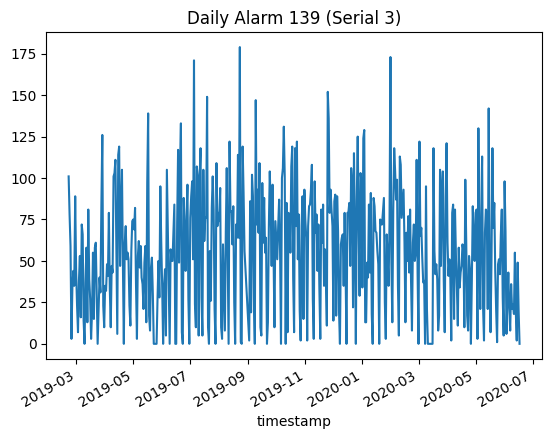

In [60]:
# Example: Analyze alarm 139 for serial 3
ts_data = pivot_df[(3, 139)]
ts_data.plot(title="Daily Alarm 139 (Serial 3)")

<Axes: title={'center': 'Daily Alarm 139 (Serial 19)'}, xlabel='timestamp'>

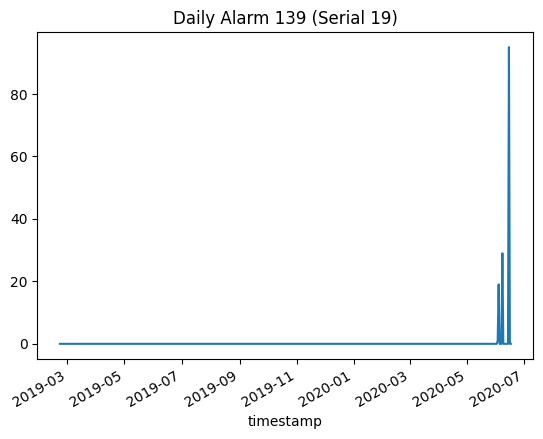

In [64]:
# Example: Analyze alarm 139 for serial 3
ts_data = pivot_df[(19, 139)]
ts_data.plot(title="Daily Alarm 139 (Serial 19)")

In [65]:
split_date = '2020-05-01'
train = ts_data.loc[:split_date]
test = ts_data.loc[split_date:]

In [67]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.9 MB/s eta 0:00:0000:01


In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Auto-select parameters using pmdarima (install first)
from pmdarima import auto_arima
model = auto_arima(train, seasonal=True, m=7)  # Weekly seasonality
forecast = model.predict(n_periods=len(test))

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [71]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = train.reset_index()
prophet_df.columns = ['ds', 'y']

# Fit model
m = Prophet(daily_seasonality=False, yearly_seasonality=True)
m.add_seasonality(name='weekly', period=7, fourier_order=3)
m.fit(prophet_df)

# Forecast
future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)

In [72]:
forecast

ds  trend    yhat_lower    yhat_upper   trend_lower   trend_upper  \
0   2019-02-21    0.0 -1.361601e-09  1.262266e-09  0.000000e+00  0.000000e+00   
1   2019-02-22    0.0 -1.255013e-09  1.306275e-09  0.000000e+00  0.000000e+00   
2   2019-02-23    0.0 -1.307173e-09  1.223852e-09  0.000000e+00  0.000000e+00   
3   2019-02-24    0.0 -1.265052e-09  1.333703e-09  0.000000e+00  0.000000e+00   
4   2019-02-25    0.0 -1.338375e-09  1.269823e-09  0.000000e+00  0.000000e+00   
..         ...    ...           ...           ...           ...           ...   
475 2020-06-14    0.0 -1.767248e-09  1.954904e-09 -1.333870e-09  1.417025e-09   
476 2020-06-15    0.0 -1.816092e-09  1.925140e-09 -1.382778e-09  1.479807e-09   
477 2020-06-16    0.0 -2.027729e-09  2.116292e-09 -1.440105e-09  1.519406e-09   
478 2020-06-17    0.0 -1.915965e-09  2.047979e-09 -1.525572e-09  1.570996e-09   
479 2020-06-18    0.0 -2.062746e-09  2.166318e-09 -1.561772e-09  1.604670e-09   

     additive_terms  additive_terms_lower  additive_terms_upper  weekly  \
0               0.0                   0.0                   0.0     0.0   
1               0.0                   0.0                   0.0     0.0   
2               0.0                   0.0                   0.0     0.0   
3               0.0                   0.0                   0.0     0.0   
4               0.0                   0.0                   0.0     0.0   
..              ...                   ...                   ...     ...   
475             0.0                   0.0                   0.0     0.0   
476             0.0                   0.0                   0.0     0.0   
477             0.0                   0.0                   0.0     0.0   
478             0.0                   0.0                   0.0     0.0   
479             0.0                   0.0                   0.0     0.0   

     weekly_lower  weekly_upper  yearly  yearly_lower  yearly_upper  \
0             0.0           0.0     0.0           0.0           0.0   
1             0.0           0.0     0.0           0.0           0.0   
2             0.0           0.0     0.0           0.0           0.0   
3             0.0           0.0     0.0           0.0           0.0   
4             0.0           0.0     0.0           0.0           0.0   
..            ...           ...     ...           ...           ...   
475           0.0           0.0     0.0           0.0           0.0   
476           0.0           0.0     0.0           0.0           0.0   
477           0.0           0.0     0.0           0.0           0.0   
478           0.0           0.0     0.0           0.0           0.0   
479           0.0           0.0     0.0           0.0           0.0   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
475                   0.0                         0.0   
476                   0.0                         0.0   
477                   0.0                         0.0   
478                   0.0                         0.0   
479                   0.0                         0.0   

     multiplicative_terms_upper  yhat  
0                           0.0   0.0  
1                           0.0   0.0  
2                           0.0   0.0  
3                           0.0   0.0  
4                           0.0   0.0  
..                          ...   ...  
475                         0.0   0.0  
476                         0.0   0.0  
477                         0.0   0.0  
478                         0.0   0.0  
479                         0.0   0.0  

[480 rows x 19 columns]

In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(f"MAE: {mean_absolute_error(test, forecast['yhat'][-len(test):])}")
print(f"RMSE: {mean_squared_error(test, forecast['yhat'][-len(test):], squared=False)}")

MAE: 3.0
RMSE: 14.597374193098338


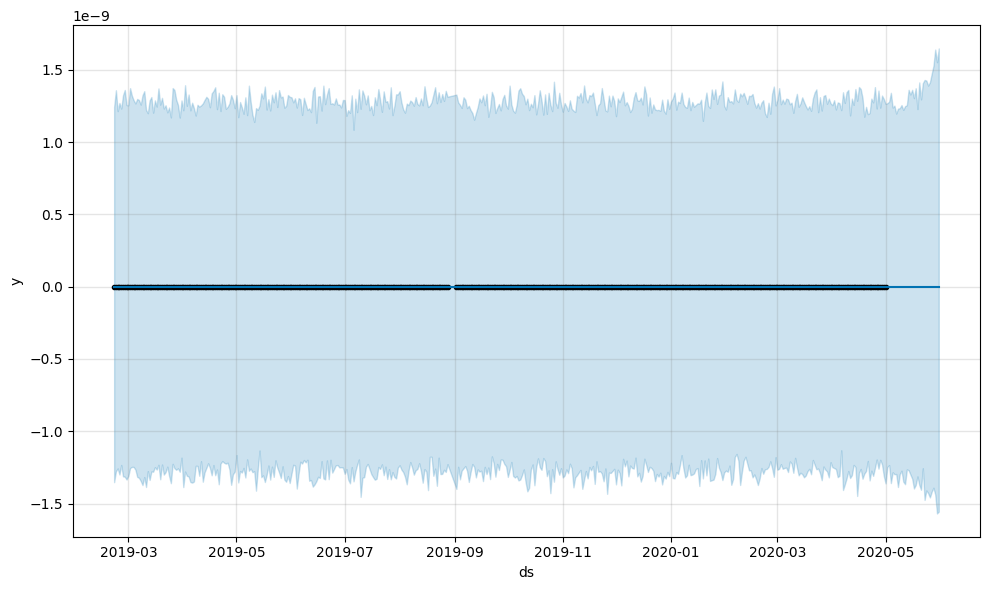

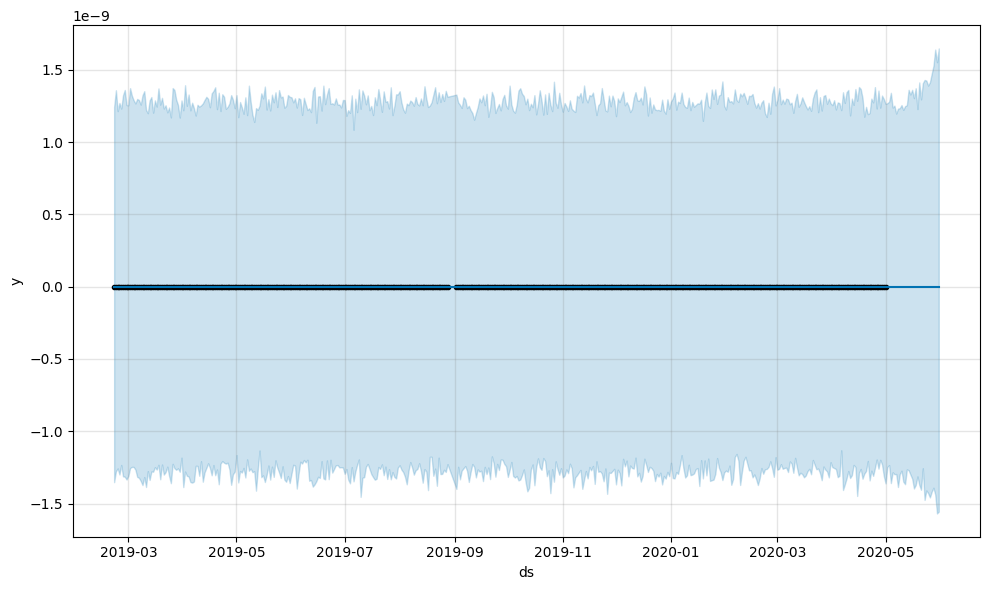

In [74]:
# Retrain on full data and predict next 30 days
full_model = Prophet().fit(prophet_df)
future = full_model.make_future_dataframe(periods=30)
forecast = full_model.predict(future)
full_model.plot(forecast)

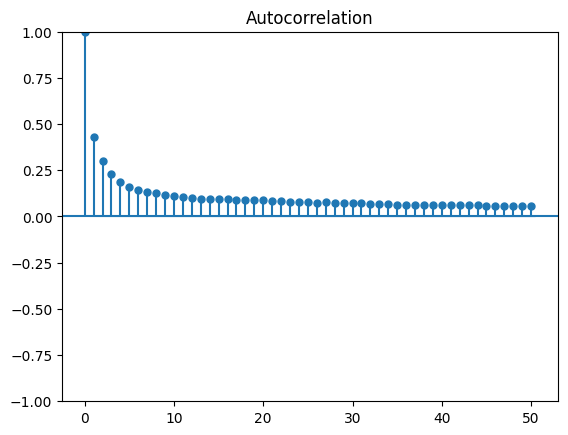

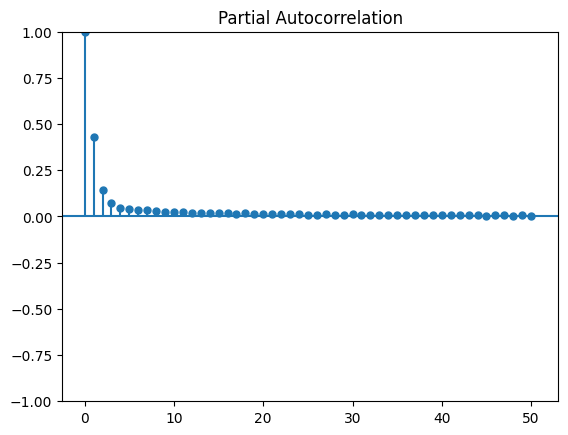

In [10]:

# Autocorrelation Plot
plot_acf(df['alarm'], lags=50)
plt.show()

# Partial Autocorrelation Plot
plot_pacf(df['alarm'], lags=50)
plt.show()

In [21]:
# Create all unique (serial, alarm) combinations
groups = df.groupby(['serial', 'alarm'])
print(f"Total groups to forecast: {len(groups)}")

Total groups to forecast: 958


In [22]:
from tqdm import tqdm
from prophet import Prophet

# Dictionary to store models and forecasts
forecast_results = {}

for (serial, alarm), group in tqdm(groups):
    # Skip groups with insufficient data
    if len(group) < 14:  # Minimum 2 weeks of data
        continue
        
    # Aggregate to daily counts
    daily = group.resample('D', on='timestamp').size().reset_index()
    daily.columns = ['ds', 'y']
    
    # Initialize and configure Prophet
    model = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=False,
        seasonality_mode='additive',
        changepoint_prior_scale=0.05
    ).add_seasonality(name='weekly', period=7, fourier_order=3)
    
    try:
        # Fit model
        model.fit(daily)
        
        # Create future dataframe (30-day forecast)
        future = model.make_future_dataframe(periods=30)
        forecast = model.predict(future)
        
        # Store results
        forecast_results[(serial, alarm)] = {
            'model': model,
            'forecast': forecast,
            'last_date': daily['ds'].max(),
            'history': daily
        }
        
    except Exception as e:
        print(f"Failed for ({serial}, {alarm}): {str(e)}")

  0%|          | 0/958 [00:00<?, ?it/s]21:20:55 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/958 [00:00<02:50,  5.61it/s]21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/958 [00:00<01:03, 15.02it/s]21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 7/958 [00:00<01:11, 13.23it/s]21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 9/958 [00:00

Failed for (3, 109): Dataframe has less than 2 non-NaN rows.


21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▍       | 238/958 [00:16<00:45, 15.99it/s]21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 242/958 [00:16<00:40, 17.54it/s]21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 244/958 [00:17<00:49, 14.57it/s]21:21:13 - cmdstanpy - INFO - Chain [1] start processing
21:21:13 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▌       | 246/958 [00:17<00:47, 14.95it/s]21:21:13 - cmdstanpy - INFO - Chain [1] start processing
21:21:13 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▌     

Failed for (5, 56): Dataframe has less than 2 non-NaN rows.


21:21:17 - cmdstanpy - INFO - Chain [1] start processing
21:21:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 319/958 [00:21<00:37, 17.19it/s]21:21:17 - cmdstanpy - INFO - Chain [1] start processing
21:21:17 - cmdstanpy - INFO - Chain [1] done processing
21:21:17 - cmdstanpy - INFO - Chain [1] start processing
21:21:17 - cmdstanpy - INFO - Chain [1] done processing
 34%|███▎      | 322/958 [00:21<00:36, 17.46it/s]21:21:17 - cmdstanpy - INFO - Chain [1] start processing
21:21:17 - cmdstanpy - INFO - Chain [1] done processing
21:21:17 - cmdstanpy - INFO - Chain [1] start processing
21:21:17 - cmdstanpy - INFO - Chain [1] done processing
 34%|███▍      | 328/958 [00:21<00:28, 22.20it/s]21:21:17 - cmdstanpy - INFO - Chain [1] start processing
21:21:17 - cmdstanpy - INFO - Chain [1] done processing
21:21:17 - cmdstanpy - INFO - Chain [1] start processing
21:21:17 - cmdstanpy - INFO - Chain [1] done processing
 35%|███▍      | 331/958 [00:22<00:32, 19.03it/s]21:21:18 - cm

Failed for (8, 16): Dataframe has less than 2 non-NaN rows.


21:21:28 - cmdstanpy - INFO - Chain [1] start processing
21:21:28 - cmdstanpy - INFO - Chain [1] done processing
21:21:28 - cmdstanpy - INFO - Chain [1] start processing
21:21:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 483/958 [00:32<00:29, 16.04it/s]21:21:28 - cmdstanpy - INFO - Chain [1] start processing
21:21:28 - cmdstanpy - INFO - Chain [1] done processing
21:21:28 - cmdstanpy - INFO - Chain [1] start processing
21:21:28 - cmdstanpy - INFO - Chain [1] done processing
 51%|█████     | 485/958 [00:32<00:34, 13.90it/s]21:21:28 - cmdstanpy - INFO - Chain [1] start processing
21:21:28 - cmdstanpy - INFO - Chain [1] done processing
21:21:28 - cmdstanpy - INFO - Chain [1] start processing
21:21:28 - cmdstanpy - INFO - Chain [1] done processing
 51%|█████     | 487/958 [00:33<00:37, 12.46it/s]21:21:28 - cmdstanpy - INFO - Chain [1] start processing
21:21:28 - cmdstanpy - INFO - Chain [1] done processing
21:21:29 - cmdstanpy - INFO - Chain [1] start processing
21:21

Failed for (9, 6): Dataframe has less than 2 non-NaN rows.
Failed for (9, 7): Dataframe has less than 2 non-NaN rows.
Failed for (9, 8): Dataframe has less than 2 non-NaN rows.


21:21:32 - cmdstanpy - INFO - Chain [1] start processing
21:21:32 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 550/958 [00:36<00:18, 22.37it/s]21:21:32 - cmdstanpy - INFO - Chain [1] start processing
21:21:32 - cmdstanpy - INFO - Chain [1] done processing
21:21:32 - cmdstanpy - INFO - Chain [1] start processing
21:21:32 - cmdstanpy - INFO - Chain [1] done processing
21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 553/958 [00:37<00:21, 18.76it/s]21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 556/958 [00:37<00:24, 16.61it/s]21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21

Failed for (9, 112): Dataframe has less than 2 non-NaN rows.


21:21:34 - cmdstanpy - INFO - Chain [1] start processing
21:21:34 - cmdstanpy - INFO - Chain [1] done processing
 60%|█████▉    | 573/958 [00:38<00:16, 23.18it/s]21:21:34 - cmdstanpy - INFO - Chain [1] start processing
21:21:34 - cmdstanpy - INFO - Chain [1] done processing
21:21:34 - cmdstanpy - INFO - Chain [1] start processing
21:21:34 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 578/958 [00:38<00:16, 23.50it/s]21:21:34 - cmdstanpy - INFO - Chain [1] start processing
21:21:34 - cmdstanpy - INFO - Chain [1] done processing
 61%|██████    | 583/958 [00:38<00:13, 27.51it/s]21:21:34 - cmdstanpy - INFO - Chain [1] start processing
21:21:34 - cmdstanpy - INFO - Chain [1] done processing
21:21:34 - cmdstanpy - INFO - Chain [1] start processing
21:21:34 - cmdstanpy - INFO - Chain [1] done processing
21:21:34 - cmdstanpy - INFO - Chain [1] start processing
21:21:34 - cmdstanpy - INFO - Chain [1] done processing
 61%|██████▏   | 587/958 [00:38<00:17, 21.52it/s]21:21:34 - cm

Failed for (11, 56): Dataframe has less than 2 non-NaN rows.


21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
 69%|██████▉   | 662/958 [00:43<00:13, 21.36it/s]21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
 70%|██████▉   | 666/958 [00:43<00:12, 22.62it/s]21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
 70%|███████   | 671/958 [00:43<00:12, 23.05it/s]21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
 70%|███████   | 674/958 [00:44<00:12, 23.26it/s]21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:40 - cm

Failed for (12, 136): Dataframe has less than 2 non-NaN rows.


 76%|███████▌  | 724/958 [00:47<00:10, 21.41it/s]21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing
21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing
 76%|███████▌  | 727/958 [00:47<00:13, 17.53it/s]21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing
21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing
 76%|███████▋  | 732/958 [00:47<00:11, 19.81it/s]21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing
21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing
 77%|███████▋  | 735/958 [00:47<00:12, 17.44it/s]21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing
21:21:43 - cm

Failed for (16, 21): Dataframe has less than 2 non-NaN rows.


21:21:53 - cmdstanpy - INFO - Chain [1] done processing
21:21:53 - cmdstanpy - INFO - Chain [1] start processing
21:21:53 - cmdstanpy - INFO - Chain [1] done processing
 90%|████████▉ | 860/958 [00:57<00:04, 20.08it/s]21:21:53 - cmdstanpy - INFO - Chain [1] start processing
21:21:53 - cmdstanpy - INFO - Chain [1] done processing
21:21:53 - cmdstanpy - INFO - Chain [1] start processing
21:21:53 - cmdstanpy - INFO - Chain [1] done processing
 90%|█████████ | 863/958 [00:57<00:04, 19.44it/s]21:21:53 - cmdstanpy - INFO - Chain [1] start processing
21:21:53 - cmdstanpy - INFO - Chain [1] done processing
21:21:53 - cmdstanpy - INFO - Chain [1] start processing
21:21:53 - cmdstanpy - INFO - Chain [1] done processing
 90%|█████████ | 866/958 [00:57<00:05, 15.79it/s]21:21:53 - cmdstanpy - INFO - Chain [1] start processing
21:21:53 - cmdstanpy - INFO - Chain [1] done processing
21:21:53 - cmdstanpy - INFO - Chain [1] start processing
21:21:53 - cmdstanpy - INFO - Chain [1] done processing
 91%|█

Failed for (16, 115): Dataframe has less than 2 non-NaN rows.


 92%|█████████▏| 883/958 [00:58<00:03, 19.84it/s]21:21:54 - cmdstanpy - INFO - Chain [1] start processing
21:21:54 - cmdstanpy - INFO - Chain [1] done processing
21:21:54 - cmdstanpy - INFO - Chain [1] start processing
21:21:54 - cmdstanpy - INFO - Chain [1] done processing
 93%|█████████▎| 889/958 [00:58<00:03, 22.42it/s]21:21:54 - cmdstanpy - INFO - Chain [1] start processing
21:21:54 - cmdstanpy - INFO - Chain [1] done processing
21:21:54 - cmdstanpy - INFO - Chain [1] start processing
21:21:54 - cmdstanpy - INFO - Chain [1] done processing
 93%|█████████▎| 892/958 [00:58<00:02, 22.06it/s]21:21:54 - cmdstanpy - INFO - Chain [1] start processing
21:21:54 - cmdstanpy - INFO - Chain [1] done processing
21:21:54 - cmdstanpy - INFO - Chain [1] start processing
21:21:54 - cmdstanpy - INFO - Chain [1] done processing
21:21:55 - cmdstanpy - INFO - Chain [1] start processing
21:21:55 - cmdstanpy - INFO - Chain [1] done processing
 93%|█████████▎| 895/958 [00:59<00:03, 17.22it/s]21:21:55 - cm

Failed for (18, 142): Dataframe has less than 2 non-NaN rows.


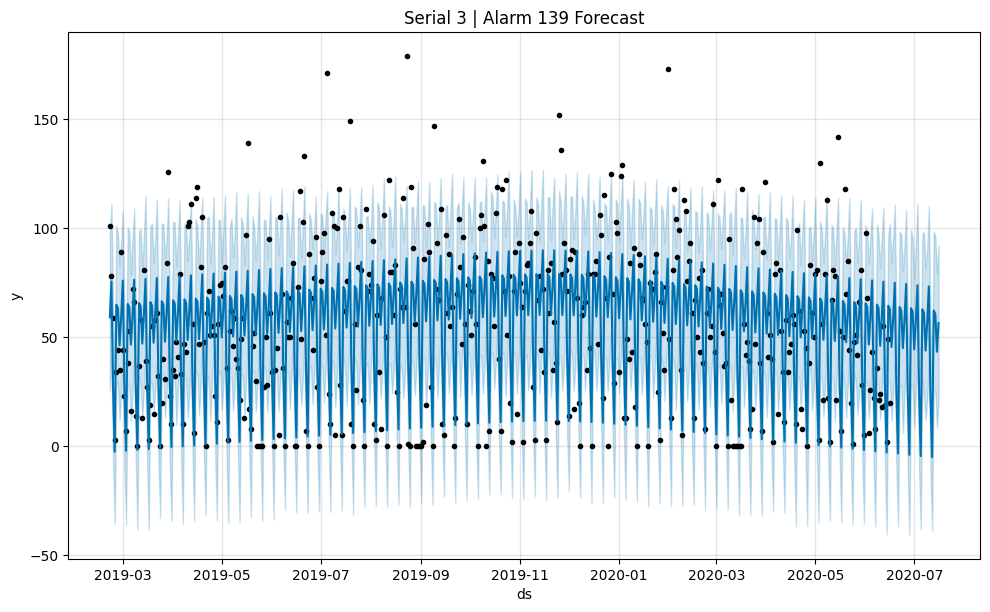

In [23]:
def plot_forecast(serial, alarm):
    key = (serial, alarm)
    if key not in forecast_results:
        print("No forecast available")
        return
    
    data = forecast_results[key]
    fig = data['model'].plot(data['forecast'])
    plt.title(f"Serial {serial} | Alarm {alarm} Forecast")
    plt.show()
    
plot_forecast(3, 139)  # Example from your data

In [11]:
## all_forecasts = []

for (serial, alarm), data in forecast_results.items():
    forecast_df = data['forecast'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast_df['serial'] = serial
    forecast_df['alarm'] = alarm
    all_forecasts.append(forecast_df)

full_export = pd.concat(all_forecasts)
full_export.to_csv("all_alarm_forecasts.csv", index=False)

<ipython-input-11-98de0ddcb849>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df['serial'] = serial
<ipython-input-11-98de0ddcb849>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df['alarm'] = alarm
<ipython-input-11-98de0ddcb849>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [12]:
data = pd.read_csv('/kaggle/working/all_alarm_forecasts.csv')
data

ds       yhat  yhat_lower  yhat_upper  serial  alarm
0                 2019-09-13  -0.037245   -0.500652    0.414106       0      0
1                 2019-09-14  -0.078838   -0.527910    0.388597       0      0
2                 2019-09-15   0.047904   -0.407477    0.530919       0      0
3                 2019-09-16   0.090490   -0.390354    0.525983       0      0
4                 2019-09-17   0.187418   -0.246526    0.654756       0      0
...                      ...        ...         ...         ...     ...    ...
4523962  2020-06-22 19:00:00  30.892493   26.295902   35.671073      19    139
4523963  2020-06-22 20:00:00  21.543827   17.977524   25.192840      19    139
4523964  2020-06-22 21:00:00  15.451895   12.545618   18.331523      19    139
4523965  2020-06-22 22:00:00  14.133228   11.262355   17.054949      19    139
4523966  2020-06-22 23:00:00  15.010590   12.167158   18.177510      19    139

[4523967 rows x 6 columns]

In [24]:
# Get maximum predicted values for next 7 days
alert_threshold = 5  # Example threshold
alerts = []

for (serial, alarm), data in forecast_results.items():
    latest = data['forecast'].tail(7)
    max_pred = latest['yhat'].max()
    
    if max_pred > alert_threshold:
        alerts.append({
            'serial': serial,
            'alarm': alarm,
            'predicted_max': max_pred,
            'expected_date': latest['ds'].iloc[-1]
        })

alert_df = pd.DataFrame(alerts)
print(f"Alerts needing attention:\n{alert_df}")

Alerts needing attention:
    serial  alarm  predicted_max expected_date
0        0     26      14.529147    2020-07-16
1        0     29       8.820867    2020-07-16
2        0     35       8.036100    2020-05-05
3        0     57      68.324267    2019-11-04
4        0     98       7.228897    2020-07-16
..     ...    ...            ...           ...
71      18     29      12.272151    2020-07-16
72      18     31      17.981155    2020-07-16
73      18     98      15.470009    2020-07-16
74      18    137       5.039969    2020-07-16
75      19    139      96.351435    2020-07-15

[76 rows x 4 columns]


In [25]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

metrics = []
for (serial, alarm), data in forecast_results.items():
    try:
        # Align forecast with historical data
        y_true = data['history'].set_index('ds')['y']
        y_pred = data['forecast'].set_index('ds')['yhat']
        
        # Ensure matching time ranges
        combined = pd.concat([y_true, y_pred], axis=1, join='inner')
        if combined.empty:
            raise ValueError("No overlapping dates for evaluation")
            
        metrics.append({
            'serial': serial,
            'alarm': alarm,
            'mae': mean_absolute_error(combined['y'], combined['yhat']),
            'mape': mean_absolute_percentage_error(combined['y'], combined['yhat'])
        })
        
    except Exception as e:
        print(f"Metrics failed for ({serial}, {alarm}): {str(e)}")
        continue  # Skip this group but continue processing

# Create DataFrame with default values
metrics_df = pd.DataFrame(metrics).fillna(np.nan)

# Safe average calculation
if not metrics_df.empty and {'mae', 'mape'}.issubset(metrics_df.columns):
    print("Average Performance:")
    print(metrics_df[['mae', 'mape']].mean())
else:
    print("No valid metrics calculated. Check model fitting errors above.")

Average Performance:
mae     1.904580e+00
mape    2.792484e+15
dtype: float64


In [15]:
# Update Prophet configuration for count data
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    growth='flat',
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.1,
    mcmc_samples=300,  # Bayesian uncertainty for sparse data
    interval_width=0.95
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=5,
    prior_scale=15.0
)

In [26]:
def safe_mape(y_true, y_pred):
    """Robust MAPE calculation handling zeros"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true > 0  # Only consider non-zero true values
    if sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]) * 100)

In [34]:
# Robust Alert System Implementation
import pandas as pd

def generate_alerts(forecast_results, alert_threshold=5, current_date=None):
    """
    Generate alerts for predicted alarm thresholds with validation
    """
    alerts = []
    
    # Use last historical date if current_date not specified
    if current_date is None:
        current_date = max([data['history']['ds'].max() 
                          for data in forecast_results.values()])
    
    for (serial, alarm), data in forecast_results.items():
        try:
            # Get future forecasts only
            future_mask = data['forecast']['ds'] > current_date
            future_forecast = data['forecast'][future_mask]
            
            if not future_forecast.empty:
                max_pred = future_forecast['yhat'].max()
                peak_date = future_forecast.loc[
                    future_forecast['yhat'].idxmax(), 'ds'
                ].strftime('%Y-%m-%d')
                
                if max_pred > alert_threshold:
                    alerts.append({
                        'serial': serial,
                        'alarm': alarm,
                        'predicted_max': max_pred,
                        'peak_date': peak_date,
                        'confidence': future_forecast['yhat_upper'].max()
                    })
                    
        except KeyError as e:
            print(f"Missing key {str(e)} in ({serial}, {alarm}) forecast")
        except Exception as e:
            print(f"Error processing ({serial}, {alarm}): {str(e)}")
    
    # Create DataFrame with fallback columns
    columns = ['serial', 'alarm', 'predicted_max', 'peak_date', 'confidence']
    alert_df = pd.DataFrame(alerts, columns=columns) if alerts else pd.DataFrame(columns=columns)
    
    return alert_df.sort_values('predicted_max', ascending=False)

# Usage with your data
alert_threshold = 5
current_date = pd.Timestamp('2020-06-17')  # Use your last historical date
alert_df = generate_alerts(forecast_results, alert_threshold, current_date)

print(f"Generated {len(alert_df)} alerts:")
print(alert_df)

Generated 61 alerts:
    serial  alarm  predicted_max   peak_date  confidence
3        0    137     100.300162  2020-07-12  193.815953
60      19    139      96.351435  2020-07-13  112.183537
12       3    139      74.972716  2020-06-19  111.577188
53      17     98      62.093684  2020-06-24  104.683691
17       7     26      41.685491  2020-07-13   75.775771
..     ...    ...            ...         ...         ...
18       7     28       5.857620  2020-07-15   13.265142
23       8     31       5.505823  2020-06-23   16.031929
20       7     31       5.371459  2020-07-12   13.671012
59      18    137       5.039969  2020-07-12    9.262474
28       9     32       5.023599  2020-06-19   15.494864

[61 rows x 5 columns]


# HOURLY


In [6]:
import pandas as pd

# Convert timestamp column to datetime and set as index
df = df.set_index(pd.to_datetime(df['timestamp'])).sort_index()

# Split using your original date boundaries
split_date = pd.Timestamp('2020-05-01')
train = df[df.index < split_date]
test = df[df.index >= split_date]

# Validate the split
print("=== Data Split Summary ===")
print(f"Total records: {len(df):,}")
print(f"Training period: {train.index.min()} to {train.index.max()}")
print(f"Training size: {len(train):,} rows ({len(train)/len(df):.1%})")
print(f"Test period: {test.index.min()} to {test.index.max()}")
print(f"Test size: {len(test):,} rows ({len(test)/len(df):.1%})")

# Check for overlap
assert train.index.max() < test.index.min(), "Data leakage detected!"

=== Data Split Summary ===
Total records: 444,834
Training period: 2019-02-21 10:16:18 to 2020-04-30 23:56:37
Training size: 401,294 rows (90.2%)
Test period: 2020-05-01 00:01:53 to 2020-06-17 03:53:51
Test size: 43,540 rows (9.8%)


In [7]:
# Convert timestamp and set as index
df = df.set_index(pd.to_datetime(df['timestamp'])).sort_index()

# 1. Choose a specific (serial, alarm) combination
target_serial = 3
target_alarm = 139

# Filter and resample to hourly counts
ts_data = df[(df['serial'] == target_serial) & 
            (df['alarm'] == target_alarm)].resample('H').size().reset_index()
ts_data.columns = ['ds', 'y']

# 2. Split data using your original split date
split_date = pd.Timestamp('2020-05-01')
train = ts_data[ts_data['ds'] < split_date]
test = ts_data[ts_data['ds'] >= split_date]

<ipython-input-7-e584c5079106>:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  (df['alarm'] == target_alarm)].resample('H').size().reset_index()


In [9]:
# 3. Configure and train Prophet model
from prophet import Prophet
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.05,
    seasonality_mode='multiplicative'
).add_seasonality(
    name='8hr_cycle',
    period=8/24,  # 8-hour cycle
    fourier_order=4,
    prior_scale=10.0
)

model.fit(train)

20:30:17 - cmdstanpy - INFO - Chain [1] start processing
20:30:18 - cmdstanpy - INFO - Chain [1] done processing


/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


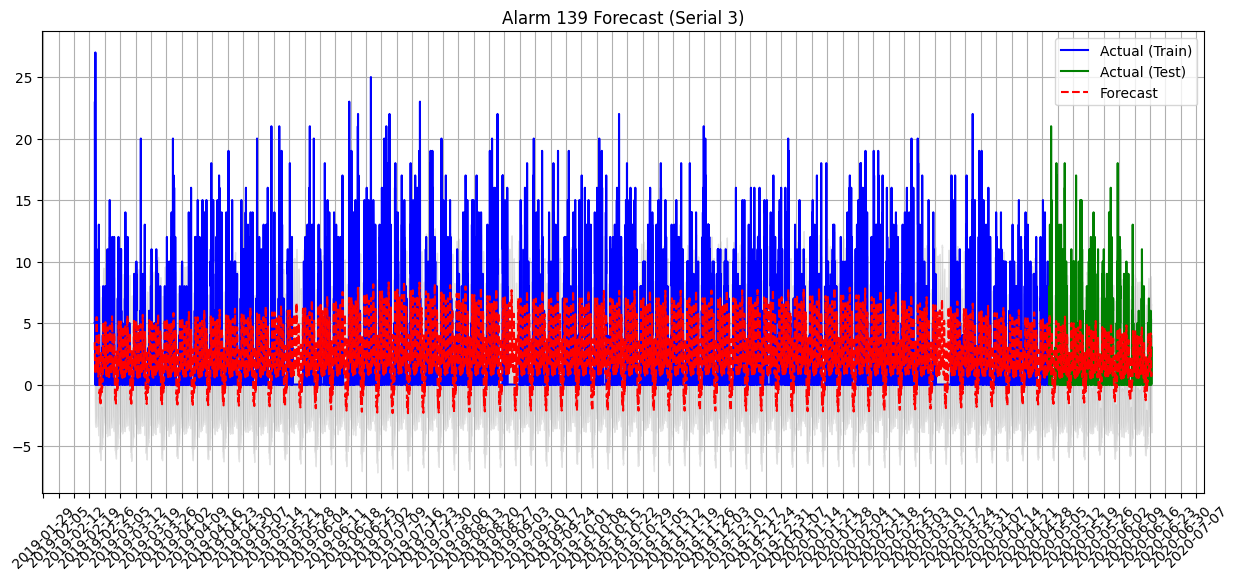

In [11]:

import matplotlib.dates as mdates
# 4. Generate forecast
future = model.make_future_dataframe(periods=len(test), freq='H')
forecast = model.predict(future)

# 5. Plot results with your data
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(train['ds'], train['y'], 'b-', label='Actual (Train)')
ax.plot(test['ds'], test['y'], 'g-', label='Actual (Test)')
ax.plot(forecast['ds'], forecast['yhat'], 'r--', label='Forecast')

ax.fill_between(forecast['ds'], 
                forecast['yhat_lower'], 
                forecast['yhat_upper'], 
                color='gray', alpha=0.2)

# Format x-axis like your original data visualization
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.title(f'Alarm {target_alarm} Forecast (Serial {target_serial})')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# 6. Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

merged = test.merge(forecast[['ds', 'yhat']], on='ds')
print(f"MAE: {mean_absolute_error(merged['y'], merged['yhat']):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(merged['y'], merged['yhat'])*100:.1f}%")

MAE: 2.18
MAPE: 413442609260482560.0%


In [13]:
def forecast_alarm_group(group, split_date):
    # Resample to hourly counts
    ts = group.resample('H').size().reset_index()
    ts.columns = ['ds', 'y']
    
    if len(ts) < 168:  # Require at least 1 week of data
        return None
        
    # Split train/test
    train = ts[ts['ds'] < split_date]
    if len(train) < 24:  # Minimum 1 day of training
        return None
        
    # Model configuration
    model = Prophet(daily_seasonality=True,
                    weekly_seasonality=True,
                    seasonality_mode='multiplicative')
    
    try:
        model.fit(train)
        future = model.make_future_dataframe(periods=24*7, freq='H')  # 1 week ahead
        forecast = model.predict(future)
        return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    except:
        return None

# Process all groups
results = {}
for (serial, alarm), group in df.groupby(['serial', 'alarm']):
    forecast = forecast_alarm_group(group, pd.Timestamp('2020-05-01'))
    if forecast is not None:
        results[(serial, alarm)] = forecast

<ipython-input-13-7bbcabef886b>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = group.resample('H').size().reset_index()
20:35:14 - cmdstanpy - INFO - Chain [1] start processing
20:35:14 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
<ipython-input-13-7bbcabef886b>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = group.resample('H').size().reset_index()
20:35:15 - cmdstanpy - INFO - Chain [1] start processing
20:35:15 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
<ipython-input-13-7bbcabef886b

In [30]:
def plot_forecast(serial, alarm, results_dict, n_last_days=7):
    """Updated version accessing correct data structure"""
    key = (serial, alarm)
    if key not in results_dict:
        print(f"No forecast available for Serial {serial} Alarm {alarm}")
        return

    # Get the stored forecast data from the results dict
    forecast_data = results_dict[key]['forecast']  # Access nested forecast DataFrame
    
    # Prepare historical data
    hist_data = df[
        (df['serial'] == serial) & 
        (df['alarm'] == alarm)
    ].resample('h').size().reset_index(name='y')
    hist_data.columns = ['ds', 'y']
    
    # Create plot
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Plot historical data
    ax.plot(hist_data['ds'], hist_data['y'], 'b-', label='Actual Events')
    
    # Plot forecast using the correct DataFrame columns
    ax.plot(forecast_data['ds'], forecast_data['yhat'], 'r--', label='Forecast')
    ax.fill_between(forecast_data['ds'], 
                    forecast_data['yhat_lower'], 
                    forecast_data['yhat_upper'], 
                    color='gray', alpha=0.2, label='Uncertainty Interval')

    # Configure date formatting
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Zoom to last n days
    if n_last_days:
        xlim_left = forecast_data['ds'].max() - pd.DateOffset(days=n_last_days)
        ax.set_xlim(xlim_left, forecast_data['ds'].max())
    
    plt.xticks(rotation=45)
    plt.title(f'Alarm {alarm} Forecast (Serial {serial})')
    plt.ylabel('Hourly Events')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [27]:
# Modified forecast_alarm_group to store both train and forecast data
def forecast_alarm_group(group, split_date):
    try:
        ts = group.resample('h', on='timestamp').size().reset_index()
        ts.columns = ['ds', 'y']
        
        if len(ts) < 168:
            return None
            
        train = ts[ts['ds'] < split_date]
        if len(train) < 24:
            return None
            
        model = Prophet(
            growth='flat',
            daily_seasonality=True,
            weekly_seasonality=True,
            seasonality_mode='multiplicative'
        )
        
        model.fit(train)
        future = model.make_future_dataframe(periods=24*7, freq='h')
        forecast = model.predict(future)
        
        # Store both train and forecast data
        return {
            'train': train,
            'forecast': forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        }
        
    except Exception as e:
        print(f"Error processing group: {str(e)}")
        return None

In [28]:
# Process groups with progress tracking
from tqdm import tqdm

results = {}
for (serial, alarm), group in tqdm(groups, desc="Processing alarms"):
    result = forecast_alarm_group(group, pd.Timestamp('2020-05-01'))
    if result is not None:
        results[(serial, alarm)] = result


Processing alarms:   0%|          | 0/958 [00:00<?, ?it/s]22:00:40 - cmdstanpy - INFO - Chain [1] start processing
22:00:40 - cmdstanpy - INFO - Chain [1] done processing
Processing alarms:   0%|          | 1/958 [00:00<08:07,  1.96it/s]22:00:41 - cmdstanpy - INFO - Chain [1] start processing
22:00:41 - cmdstanpy - INFO - Chain [1] done processing
Processing alarms:   0%|          | 2/958 [00:01<11:21,  1.40it/s]22:00:41 - cmdstanpy - INFO - Chain [1] start processing
22:00:41 - cmdstanpy - INFO - Chain [1] done processing
Processing alarms:   0%|          | 3/958 [00:02<11:02,  1.44it/s]22:00:42 - cmdstanpy - INFO - Chain [1] start processing
22:00:42 - cmdstanpy - INFO - Chain [1] done processing
Processing alarms:   0%|          | 4/958 [00:02<08:11,  1.94it/s]22:00:42 - cmdstanpy - INFO - Chain [1] start processing
22:00:42 - cmdstanpy - INFO - Chain [1] done processing
Processing alarms:   1%|          | 5/958 [00:02<07:57,  2.00it/s]22:00:43 - cmdstanpy - INFO - Chain [1] start p

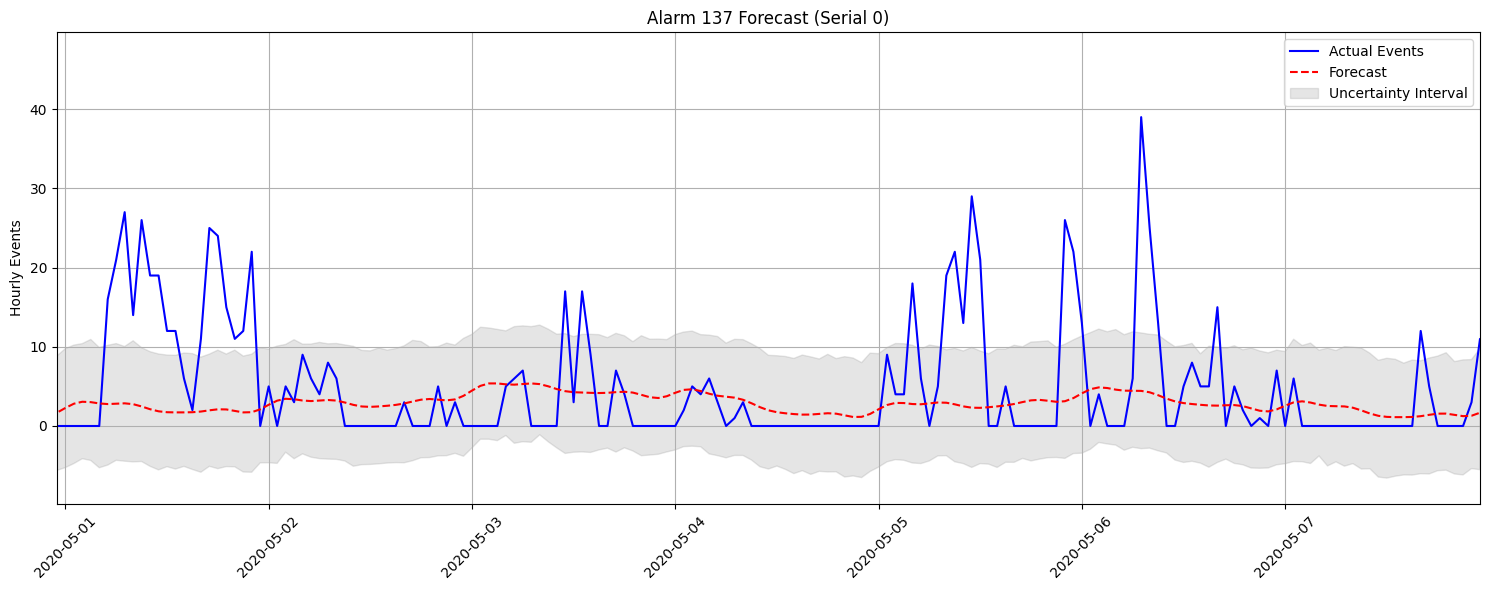

In [37]:
# Visualize specific alarm
plot_forecast(0, 137, results)

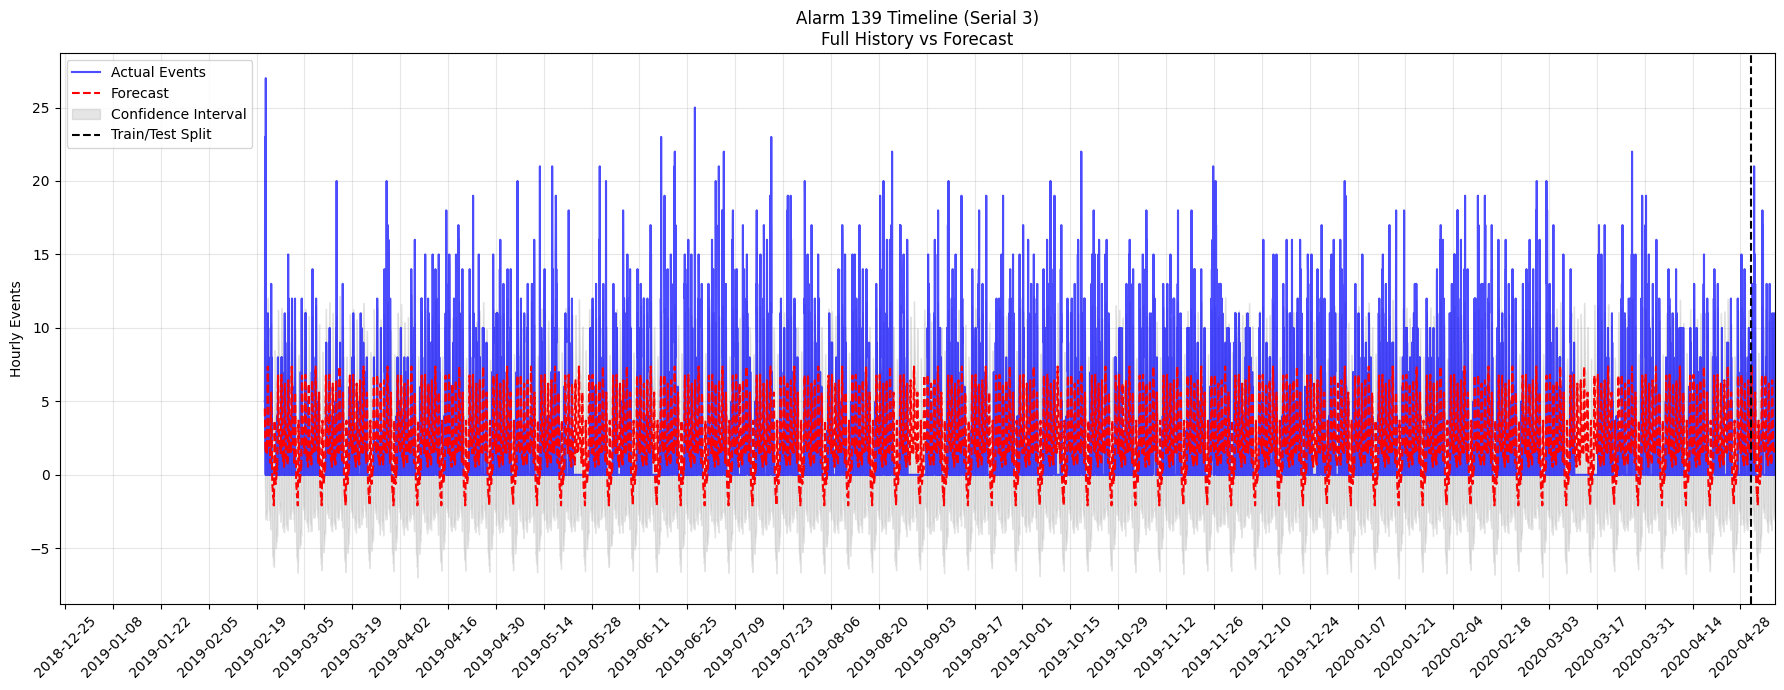

In [43]:
def plot_full_timeline(serial, alarm, results_dict, days_before_forecast=30):
    """Plot complete historical data with forecast"""
    key = (serial, alarm)
    if key not in results_dict:
        print(f"No forecast available for Serial {serial} Alarm {alarm}")
        return

    # Get stored data
    forecast_df = results_dict[key]['forecast']
    train_df = results_dict[key]['train']
    
    # Prepare complete historical data
    full_hist = df[
        (df['serial'] == serial) & 
        (df['alarm'] == alarm)
    ].resample('h').size().reset_index(name='y')
    full_hist.columns = ['ds', 'y']
    
    # Create plot
    fig, ax = plt.subplots(figsize=(18, 7))
    
    # Plot complete historical data
    ax.plot(full_hist['ds'], full_hist['y'], 'b-', label='Actual Events', alpha=0.7)
    
    # Plot forecasted data
    ax.plot(forecast_df['ds'], forecast_df['yhat'], 'r--', label='Forecast')
    ax.fill_between(forecast_df['ds'], 
                    forecast_df['yhat_lower'], 
                    forecast_df['yhat_upper'], 
                    color='gray', alpha=0.2, label='Confidence Interval')
    
    # Add training/test split line
    split_date = pd.Timestamp('2020-05-01')
    ax.axvline(split_date, color='k', linestyle='--', label='Train/Test Split')
    
    # Configure date formatting
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Set intelligent time window
    forecast_start = forecast_df['ds'].min()
    xlim_left = forecast_start - pd.DateOffset(days=days_before_forecast)
    ax.set_xlim(xlim_left, forecast_df['ds'].max())
    
    plt.xticks(rotation=45)
    plt.title(f'Alarm {alarm} Timeline (Serial {serial})\nFull History vs Forecast')
    plt.ylabel('Hourly Events')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Usage
plot_full_timeline(3, 139, results, days_before_forecast=60)

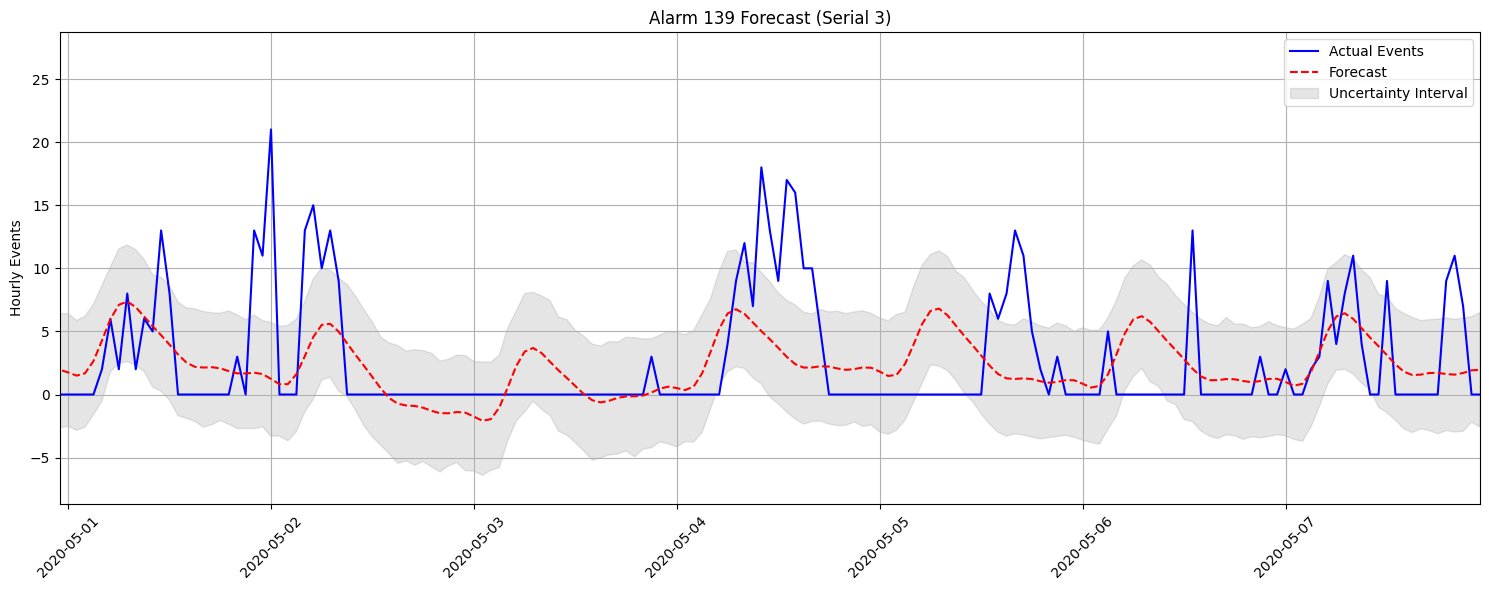

In [23]:
# Visualize specific alarm
plot_forecast(3, 139, results)

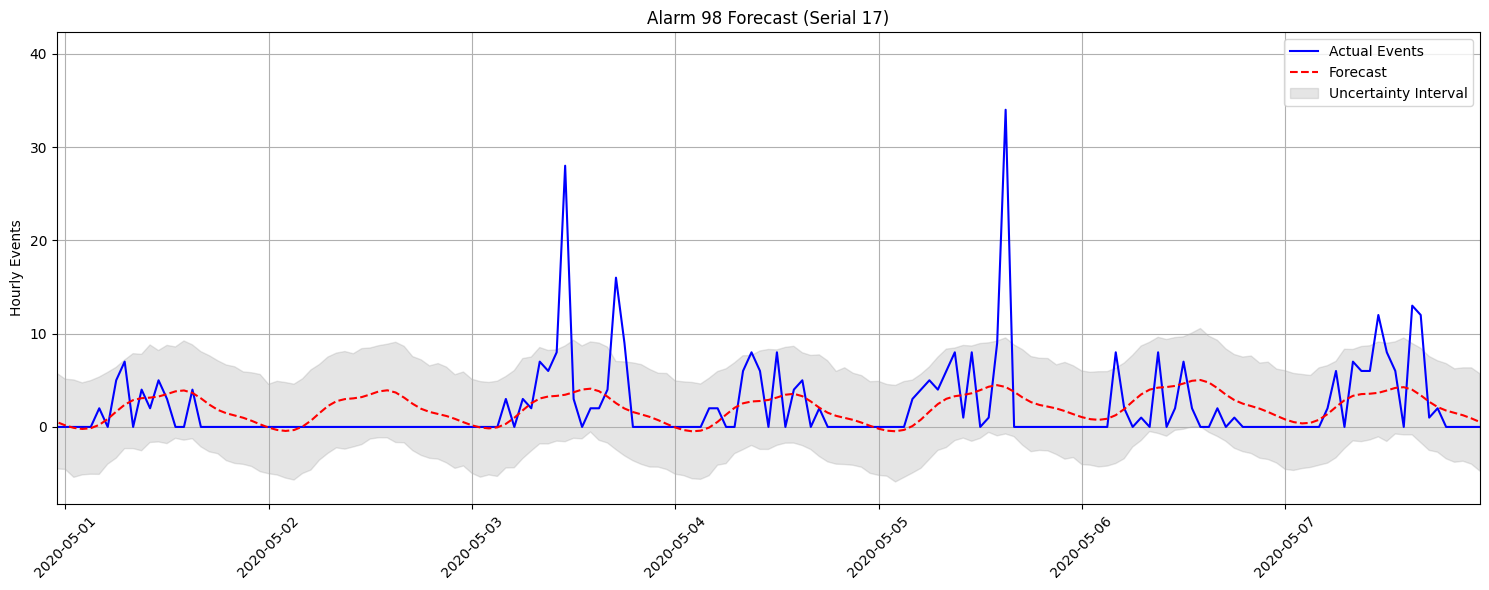

In [39]:
# Visualize specific alarm
plot_forecast(17, 98, results)

In [48]:
# Generate predictions for next week
def get_predictions(results_dict, serial, alarm):
    key = (serial, alarm)
    if key not in results_dict:
        return None
    return results_dict[key]['forecast'].set_index('ds')

predictions = get_predictions(results, target_serial, target_alarm)
print(predictions)

                         yhat  yhat_lower  yhat_upper
ds                                                   
2019-02-21 10:00:00  4.508999    0.413817    9.165868
2019-02-21 11:00:00  3.825105   -0.799826    8.211104
2019-02-21 12:00:00  3.114260   -1.177261    7.451709
2019-02-21 13:00:00  2.386897   -2.075627    6.715292
2019-02-21 14:00:00  1.807811   -2.710819    5.863474
...                       ...         ...         ...
2020-05-07 19:00:00  1.621273   -3.048803    6.034418
2020-05-07 20:00:00  1.574957   -2.583724    6.074430
2020-05-07 21:00:00  1.704544   -2.754828    6.418185
2020-05-07 22:00:00  1.915461   -2.591284    6.468583
2020-05-07 23:00:00  1.966589   -2.329399    6.393169

[10598 rows x 3 columns]


In [50]:
from sklearn.metrics import mean_absolute_error

# Initialize metrics storage
validation_metrics = []

# Use your existing results dictionary
for (serial, alarm), data in results.items():  # Changed from forecast_results to results
    try:
        # Access stored data correctly
        if 'train' not in data or 'forecast' not in data:
            continue
            
        # Use last 24 hours of training data for validation
        train_data = data['train']
        test_hours = 24
        
        if len(train_data) < test_hours * 2:  # Ensure enough data
            continue
            
        # Split train/validation
        train = train_data[:-test_hours]
        val = train_data[-test_hours:]
        
        # Rebuild model with original configuration
        model = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            changepoint_prior_scale=0.1,
            seasonality_mode='multiplicative'
        ).add_seasonality(
            name='8hr_cycle',
            period=8/24,
            fourier_order=4
        ).fit(train)
        
        # Generate validation forecast
        future = model.make_future_dataframe(periods=test_hours, freq='h')  # Use 'h' instead of 'H'
        forecast = model.predict(future)
        
        # Calculate metrics
        validation_metrics.append({
            'serial': serial,
            'alarm': alarm,
            'mae': mean_absolute_error(val['y'], forecast['yhat'][-test_hours:]),
            'coverage': ((val['y'] >= forecast['yhat_lower'][-test_hours:]) & 
                       (val['y'] <= forecast['yhat_upper'][-test_hours:])).mean()
        })
        
    except Exception as e:
        print(f"Validation failed for ({serial}, {alarm}): {str(e)}")

# Convert to DataFrame
metrics_df = pd.DataFrame(validation_metrics)
print("\nValidation Metrics Summary:")
print(metrics_df.describe().loc[['mean', 'std', 'min', 'max']])

22:23:23 - cmdstanpy - INFO - Chain [1] start processing
22:23:24 - cmdstanpy - INFO - Chain [1] done processing
22:23:25 - cmdstanpy - INFO - Chain [1] start processing
22:23:25 - cmdstanpy - INFO - Chain [1] done processing
22:23:26 - cmdstanpy - INFO - Chain [1] start processing
22:23:28 - cmdstanpy - INFO - Chain [1] done processing
22:23:29 - cmdstanpy - INFO - Chain [1] start processing
22:23:30 - cmdstanpy - INFO - Chain [1] done processing
22:23:30 - cmdstanpy - INFO - Chain [1] start processing
22:23:31 - cmdstanpy - INFO - Chain [1] done processing
22:23:31 - cmdstanpy - INFO - Chain [1] start processing
22:23:32 - cmdstanpy - INFO - Chain [1] done processing
22:23:33 - cmdstanpy - INFO - Chain [1] start processing
22:23:34 - cmdstanpy - INFO - Chain [1] done processing
22:23:34 - cmdstanpy - INFO - Chain [1] start processing
22:23:35 - cmdstanpy - INFO - Chain [1] done processing
22:23:36 - cmdstanpy - INFO - Chain [1] start processing
22:23:37 - cmdstanpy - INFO - Chain [1]


Validation Metrics Summary:
         serial       alarm           mae  coverage
mean   7.861777   56.543018  1.487576e-01  0.963564
std    5.154184   41.561946  2.941227e-01  0.056239
min    0.000000    0.000000  5.686039e-07  0.541667
max   18.000000  153.000000  2.459999e+00  1.000000


In [38]:
# Filter out non-alarm events
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').sort_index()
df = df[df['alarm'] != 0]  # If 0 indicates non-alarm state

<ipython-input-38-a29e41a91b54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])


In [39]:
def resample_group(group):
    """Resample to daily counts for each (serial, alarm) pair"""
    return group.resample('D').size().reset_index().rename(
        columns={'timestamp': 'ds', 0: 'y'}
    )

groups = df.groupby(['serial', 'alarm'])
valid_groups = [g for g in groups if len(resample_group(g[1])) >= 14]  # Min 2 weeks
print(f"Valid groups for forecasting: {len(valid_groups)}/{len(groups)}")

Valid groups for forecasting: 690/940


In [45]:
from prophet import Prophet

def create_prophet_model():
    """Configure Prophet for alarm count data"""
    return Prophet(
        growth='flat',  # Prevent negative forecasts
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=False,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.1,
        mcmc_samples=300,  # Better uncertainty for sparse data
        interval_width=0.95
    ).add_seasonality(
        name='48h_cycle',
        period=2,
        fourier_order=5,
        prior_scale=15.0
    )

In [46]:
from tqdm import tqdm
from joblib import Parallel, delayed

def process_group(serial, alarm, group):
    try:
        # Resample and filter
        daily = resample_group(group)
        if len(daily) < 14 or daily['y'].sum() < 5:
            return None
            
        # Split data
        split_date = pd.Timestamp('2020-05-01')
        train = daily[daily['ds'] < split_date]
        
        # Train model
        model = create_prophet_model()
        model.fit(train)
        
        # Generate forecast
        future = model.make_future_dataframe(periods=60)  # 2-month forecast
        forecast = model.predict(future)
        
        return (serial, alarm), {
            'model': model,
            'forecast': forecast,
            'history': daily
        }
    except Exception as e:
        print(f"Error ({serial}, {alarm}): {str(e)}")
        return None

# Parallel processing
results = Parallel(n_jobs=-1)(
    delayed(process_group)(s, a, g) for (s, a), g in tqdm(valid_groups))
forecast_results = {k:v for k,v in results if v is not None}



  8%|▊         | 55/690 [06:05<1:10:23,  6.65s/it]A

100%|██████████| 690/690 [1:04:19<00:00,  5.59s/it]


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
def generate_alerts(forecast_results, last_historical_date='2020-06-17', threshold=5):
    alerts = []
    for (serial, alarm), data in forecast_results.items():
        future = data['forecast'][data['forecast']['ds'] > last_historical_date]
        if not future.empty:
            max_pred = future['yhat'].max()
            if max_pred > threshold:
                alerts.append({
                    'serial': serial,
                    'alarm': alarm,
                    'peak_value': max_pred,
                    'peak_date': future['ds'].loc[future['yhat'].idxmax()].date(),
                    'confidence': future['yhat_upper'].max()
                })
    return pd.DataFrame(alerts).sort_values('peak_value', ascending=False)

alert_df = generate_alerts(forecast_results)
print(f"Critical alerts:\n{alert_df.head()}")

In [ ]:
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true > 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if sum(mask) else np.nan

metrics = []
for (s, a), data in forecast_results.items():
    merged = data['history'].merge(data['forecast'], on='ds')
    if not merged.empty:
        metrics.append({
            'serial': s,
            'alarm': a,
            'mae': mean_absolute_error(merged['y'], merged['yhat']),
            'smape': safe_mape(merged['y'], merged['yhat'])
        })

metrics_df = pd.DataFrame(metrics)
print(f"Average SMAPE: {metrics_df['smape'].median():.1f}%")

In [ ]:
def plot_forecast(serial, alarm):
    data = forecast_results.get((serial, alarm))
    if not data:
        return
    
    fig = data['model'].plot(data['forecast'])
    plt.title(f"Serial {serial} Alarm {alarm} Forecast")
    plt.axvline(x=pd.Timestamp('2020-05-01'), color='r', linestyle='--')
    plt.show()

plot_forecast(3, 139)  # Example plot

In [3]:
df = pd.read_csv("/kaggle/input/alarms/alarms_log_data/raw/alarms.csv")
df

timestamp  alarm  serial
0       2019-02-21 19:57:57.532    139       4
1       2019-02-21 19:58:28.293    139       4
2       2019-02-21 19:58:32.853    139       4
3       2019-02-21 19:59:05.387    139       4
4       2019-02-21 20:02:05.832    139       4
...                         ...    ...     ...
444829  2020-06-15 22:53:05.303    139      19
444830  2020-06-15 22:56:19.633    139      19
444831  2020-06-15 23:03:16.854    139      19
444832  2020-06-15 23:03:50.454    139      19
444833  2020-06-15 23:14:46.234     98      19

[444834 rows x 3 columns]

In [34]:
df_grouped = df.groupby(['serial', 'alarm'])['timestamp'].count().to_frame(name="count")
df_grouped

count
serial alarm       
0      0         15
       1        134
       10         8
       14         6
       17        96
...             ...
19     89         1
       94         2
       98        26
       138        2
       139      144

[958 rows x 1 columns]

serial
0     36129
1     14509
2     17399
3     42387
4      2118
5     18646
6     59357
7     50683
8     10972
9     22178
10    49670
11     8202
12    26068
13    37022
14    24399
15     9620
16     3569
17     8872
18     2813
19      221
Name: count, dtype: int64


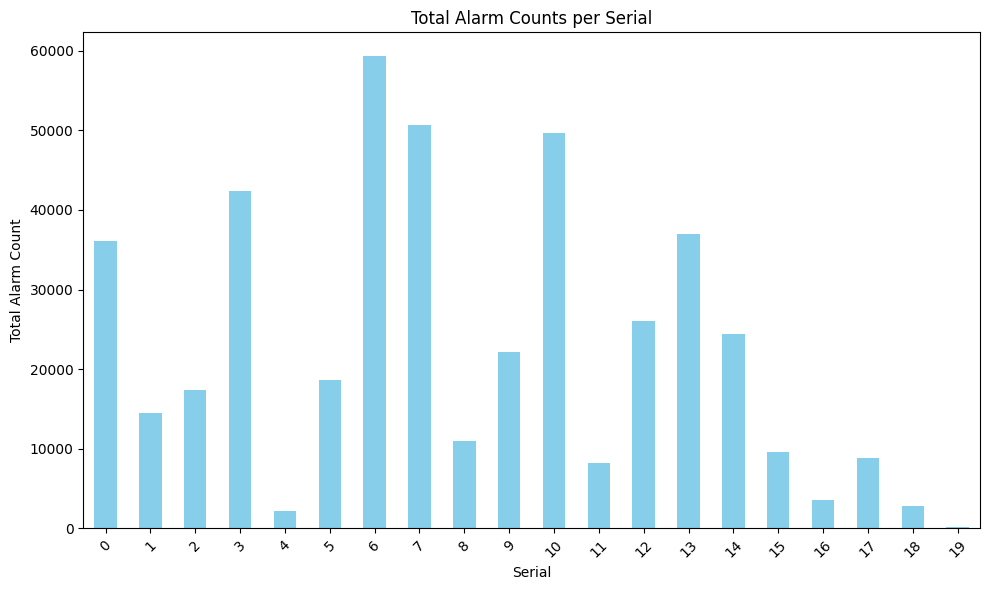

In [37]:
# **Graph 1: Bar Graph of Total Alarm Counts per Serial**
total_per_serial = df_grouped.groupby('serial')['count'].sum()
print(total_per_serial)

plt.figure(figsize=(10, 6))
total_per_serial.plot(kind='bar', color='skyblue')
plt.title('Total Alarm Counts per Serial')
plt.xlabel('Serial')
plt.ylabel('Total Alarm Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
# **Graph 2: Bar Graph of Top 10 Alarm Types by Total Count**
total_per_alarm = df_grouped.groupby('alarm')['count'].sum().sort_values(ascending=False).head(10)
print(total_per_alarm)
plt.figure(figsize=(10, 6))
total_per_alarm.plot(kind='bar', color='salmon')
plt.title('Top 10 Alarm Types by Total Count')
plt.xlabel('Alarm Type')
plt.ylabel('Total Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

alarm
98     90762
11     60994
26     57320
137    57273
139    48551
29     30092
31     24692
21     10030
32      9374
28      5698
Name: count, dtype: int64


<Figure size 1200x700 with 0 Axes>

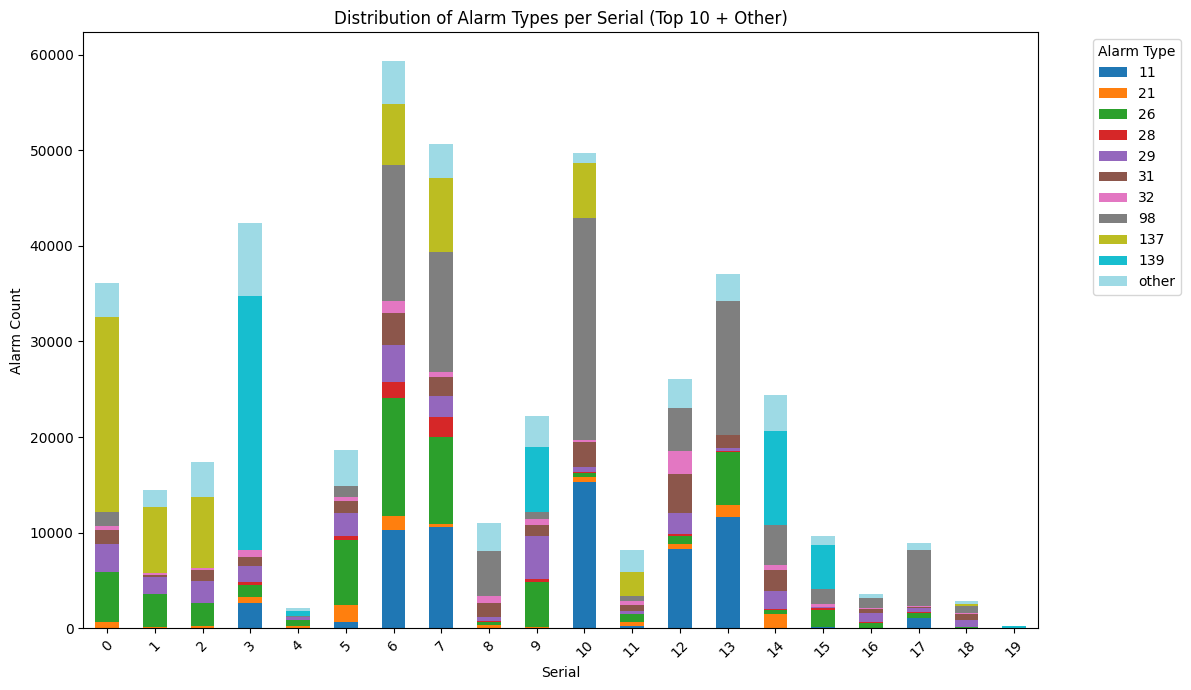

In [41]:
# **Graph 3: Stacked Bar Graph of Alarm Type Distribution per Serial**
# Identify top 10 alarm types
top_alarms = total_per_alarm.index[:10]

# Pivot the data for stacking
pivot_df = df_grouped.pivot_table(index='serial', columns='alarm', values='count', fill_value=0)

# Separate top alarms and 'other'
top_alarms_data = pivot_df[[col for col in pivot_df.columns if col in top_alarms]]
other_alarms = pivot_df[[col for col in pivot_df.columns if col not in top_alarms]].sum(axis=1)
stacked_data = pd.concat([top_alarms_data, other_alarms.rename('other')], axis=1)

# Plot stacked bar graph
plt.figure(figsize=(12, 7))
stacked_data.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 7))
plt.title('Distribution of Alarm Types per Serial (Top 10 + Other)')
plt.xlabel('Serial')
plt.ylabel('Alarm Count')
plt.xticks(rotation=45)
plt.legend(title='Alarm Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [64]:
df_grouped = df.groupby('serial')[['timestamp','alarm']]
df_grouped

In [65]:
df_grouped = df.groupby('serial').agg({'timestamp': 'count', 'alarm': 'nunique'})
df_grouped


timestamp  alarm
serial                  
0           36129     58
1           14509     69
2           17399     54
3           42387     64
4            2118     34
5           18646     50
6           59357     69
7           50683     72
8           10972     67
9           22178     36
10          49670     50
11           8202     53
12          26068     45
13          37022     43
14          24399     46
15           9620     38
16           3569     33
17           8872     33
18           2813     31
19            221     13

In [66]:
df_grouped = df.groupby(['serial', 'alarm']).size().unstack(fill_value=0)
df_grouped


alarm   0    1    2    3    4    5    6    7     8    9    ...  144  145  146  \
serial                                                     ...                  
0        15  134    0    0    0    0    0    0     0    0  ...   68    0    4   
1        14   40    0    0   16    3    0    0     0    0  ...   28    0    0   
2        17   23    0    9    0    4    0    0     0    0  ...    0    2    0   
3         3   29    0    3    0    0    0    0     0  119  ...    0    0    0   
4         2    3    0    0    0    0    0    0     0    0  ...    0    0    0   
5       103   89    0    1    0   40    0    0     0    0  ...    0    0    0   
6        28   15    0    0    0   37    0    0     0    5  ...    0    0    0   
7        29   25    0    0    0   15    0    0     0    3  ...    0    0    0   
8        21   17    0    0    0    4    0    0     0    0  ...    0    0    0   
9        22   93    2    0    0    0  438  198  1663    0  ...    0    0    0   
10        0   21    0    6    0    3    0    0     0    0  ...    0    0    0   
11        1    8    0    0    0   16    0    0     0    0  ...    0    0    0   
12       26   14    0    0    2   19    0    0     0    0  ...    0    0    0   
13        1    9    0  240    0    0    0    0     0   50  ...    0    0    0   
14       14   32    0    0    0    1    0    0     0    0  ...    0    0    0   
15        9   72    0    3    0    0    0    0     0    0  ...    0    0    0   
16        2   12    0    0    0   12    0    0     0    0  ...    0    0    0   
17        5   24    0    1    0    1    0    0     0    0  ...    0    0    0   
18        3    0    0    0    0    0    0    0     0    0  ...    0    0    0   
19        0    0    0    0    0    0    0    0     0    0  ...    0    0    0   

alarm   147  148  149  150  151  152  153  
serial                                     
0         0    3    0    0    0    0    0  
1         0    0    0    0    0    0    0  
2         1   31    0    0    0    0    0  
3         0    0    0    0    0    0    0  
4         0    0    0    0    0    0    0  
5         0    0    0    0    0    0    0  
6         0    0    0    0    0    0    0  
7         0    0    0    0    0    0    0  
8         0    0    0    0    0    0    0  
9         0    0    0    0    0    0    0  
10        0    0    0    0    0    0    0  
11        0    0    0    0    0    0    0  
12        0    0    0    0    0    0    0  
13        0    0    0    6  131    5    8  
14        0    0    0    0    0    0    0  
15        0    3    0    0    0    0    0  
16        0    0    0    0    0    0    0  
17        0    0    4    0    0    1    0  
18        0    0    0    0    0    0    0  
19        0    0    0    0    0    0    0  

[20 rows x 154 columns]

In [1]:
import pandas as pd

# Load data
df = pd.read_csv("/kaggle/input/alarms/alarms_log_data/raw/alarms.csv")

# Ensure timestamp is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Find the most frequent alarm (mode) for each serial
target_alarm = df.groupby('serial')['alarm'].agg(lambda x: x.mode()[0])

# Merge with original DataFrame to keep timestamp
df_result = df.merge(target_alarm.rename('y'), on='serial', how='left')

# Rename timestamp column to ds
df_result = df_result.rename(columns={'timestamp': 'ds', 'serial':'unique_id'})

# Select required columns
df_result = df_result[['unique_id', 'ds', 'y']]
# Display result
df_result.head()


unique_id                      ds   y
0          4 2019-02-21 19:57:57.532  26
1          4 2019-02-21 19:58:28.293  26
2          4 2019-02-21 19:58:32.853  26
3          4 2019-02-21 19:59:05.387  26
4          4 2019-02-21 20:02:05.832  26

In [2]:
df_result

unique_id                      ds    y
0               4 2019-02-21 19:57:57.532   26
1               4 2019-02-21 19:58:28.293   26
2               4 2019-02-21 19:58:32.853   26
3               4 2019-02-21 19:59:05.387   26
4               4 2019-02-21 20:02:05.832   26
...           ...                     ...  ...
444829         19 2020-06-15 22:53:05.303  139
444830         19 2020-06-15 22:56:19.633  139
444831         19 2020-06-15 23:03:16.854  139
444832         19 2020-06-15 23:03:50.454  139
444833         19 2020-06-15 23:14:46.234  139

[444834 rows x 3 columns]

In [3]:
df_result['ds'] = df_result['ds'].dt.floor('S')  # Round down to the nearest second


<ipython-input-3-95f648d257ae>:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_result['ds'] = df_result['ds'].dt.floor('S')  # Round down to the nearest second


In [4]:
df_result

unique_id                  ds    y
0               4 2019-02-21 19:57:57   26
1               4 2019-02-21 19:58:28   26
2               4 2019-02-21 19:58:32   26
3               4 2019-02-21 19:59:05   26
4               4 2019-02-21 20:02:05   26
...           ...                 ...  ...
444829         19 2020-06-15 22:53:05  139
444830         19 2020-06-15 22:56:19  139
444831         19 2020-06-15 23:03:16  139
444832         19 2020-06-15 23:03:50  139
444833         19 2020-06-15 23:14:46  139

[444834 rows x 3 columns]

In [6]:
!pip install nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 61.3 MB/s eta 0:00:0000:0100:01


In [7]:
from nixtla import NixtlaClient

nixtla_client = NixtlaClient(
    api_key = 'nixak-BAN1BMn2ZO8e9Y6IROMVc7BaULgpqrpw2MCYVjoSxktYoqx3lLeMq7nOvkqLJxKmRXd02Mg3VTPWZK8e'
)



In [8]:
nixtla_client.validate_api_key()

True

In [9]:
df_result

unique_id                  ds    y
0               4 2019-02-21 19:57:57   26
1               4 2019-02-21 19:58:28   26
2               4 2019-02-21 19:58:32   26
3               4 2019-02-21 19:59:05   26
4               4 2019-02-21 20:02:05   26
...           ...                 ...  ...
444829         19 2020-06-15 22:53:05  139
444830         19 2020-06-15 22:56:19  139
444831         19 2020-06-15 23:03:16  139
444832         19 2020-06-15 23:03:50  139
444833         19 2020-06-15 23:14:46  139

[444834 rows x 3 columns]

In [10]:
df_result['ds'] = pd.to_datetime(df_result['ds'])
df_result= df_result.set_index('ds')

In [ ]:
# Add an event column for counting
df_result['event'] = 1

# Group by 'serial' and resample to hourly, counting events
df_resampled = df_result.groupby('unique_id').resample('min')['event'].sum().reset_index()

# Rename 'event' to 'y' for the target variable
df_resampled = df_resampled.rename(columns={'event': 'y'})

df_resampled

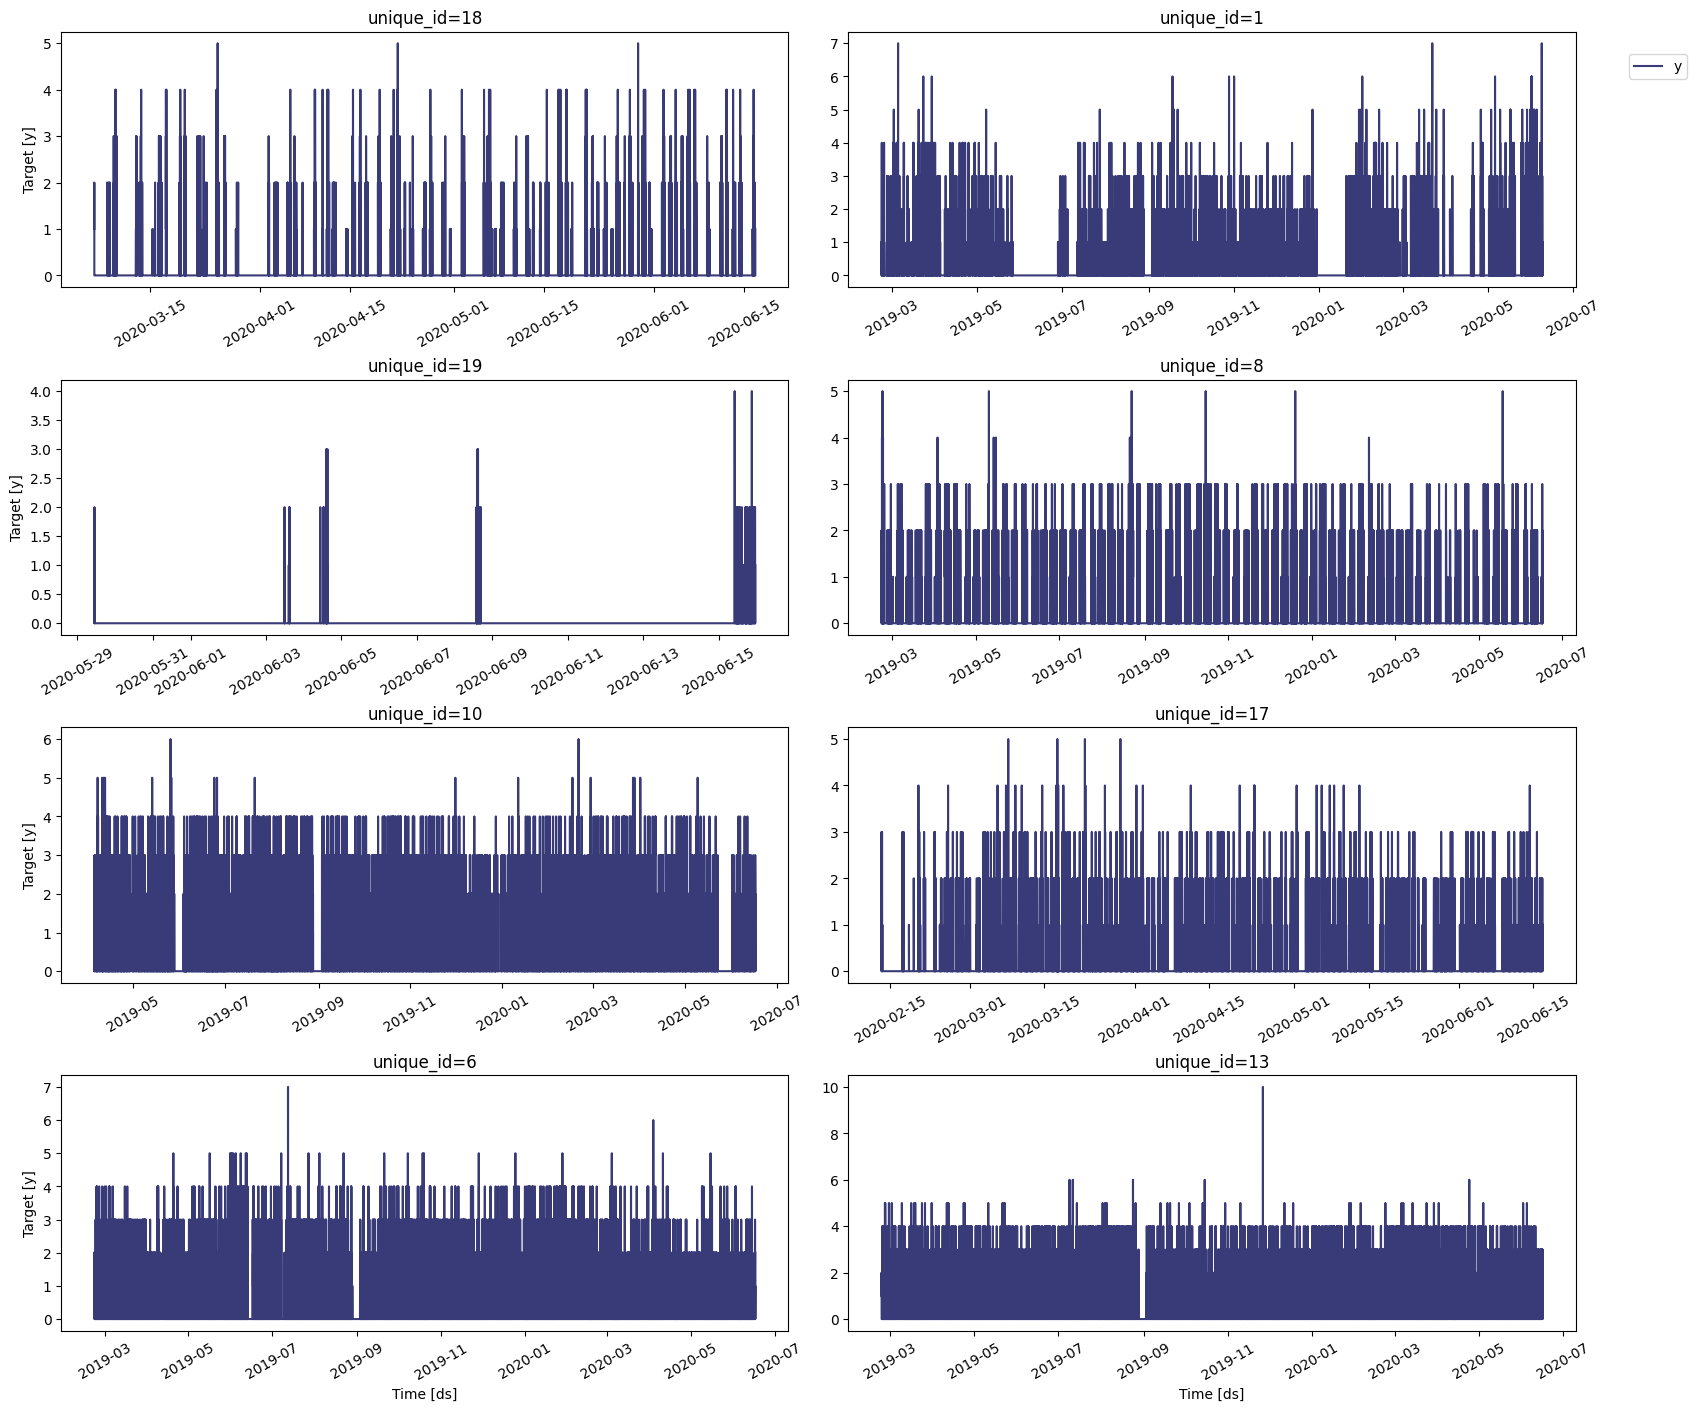

In [13]:
nixtla_client.plot(
    df_resampled, 
)

In [13]:
# Define the new window size and forecast horizon
input_window = 44640  # 1 day of historical data
horizon = 120 # 2 hour to predict

# Check which unique_ids have enough data
data_counts = df_resampled.groupby('unique_id').size()
sufficient_data_ids = data_counts[data_counts >= input_window + horizon].index

# Select the historical data (input window)
input_df = df_resampled[df_resampled['unique_id'].isin(sufficient_data_ids)].groupby('unique_id').apply(
    lambda group: group.iloc[-(input_window + horizon):-horizon]
).reset_index(drop=True)

# Select the data to predict (forecast horizon)
test_df = df_resampled[df_resampled['unique_id'].isin(sufficient_data_ids)].groupby('unique_id').tail(horizon)

<ipython-input-13-ddd4d4e5c1ae>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  input_df = df_resampled[df_resampled['unique_id'].isin(sufficient_data_ids)].groupby('unique_id').apply(


In [14]:
import time
import requests
start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    h=96,                            
    level=[90],                        # Generate a 90% confidence interval
    finetune_steps=10,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

Time (TimeGPT): 3.2357587814331055


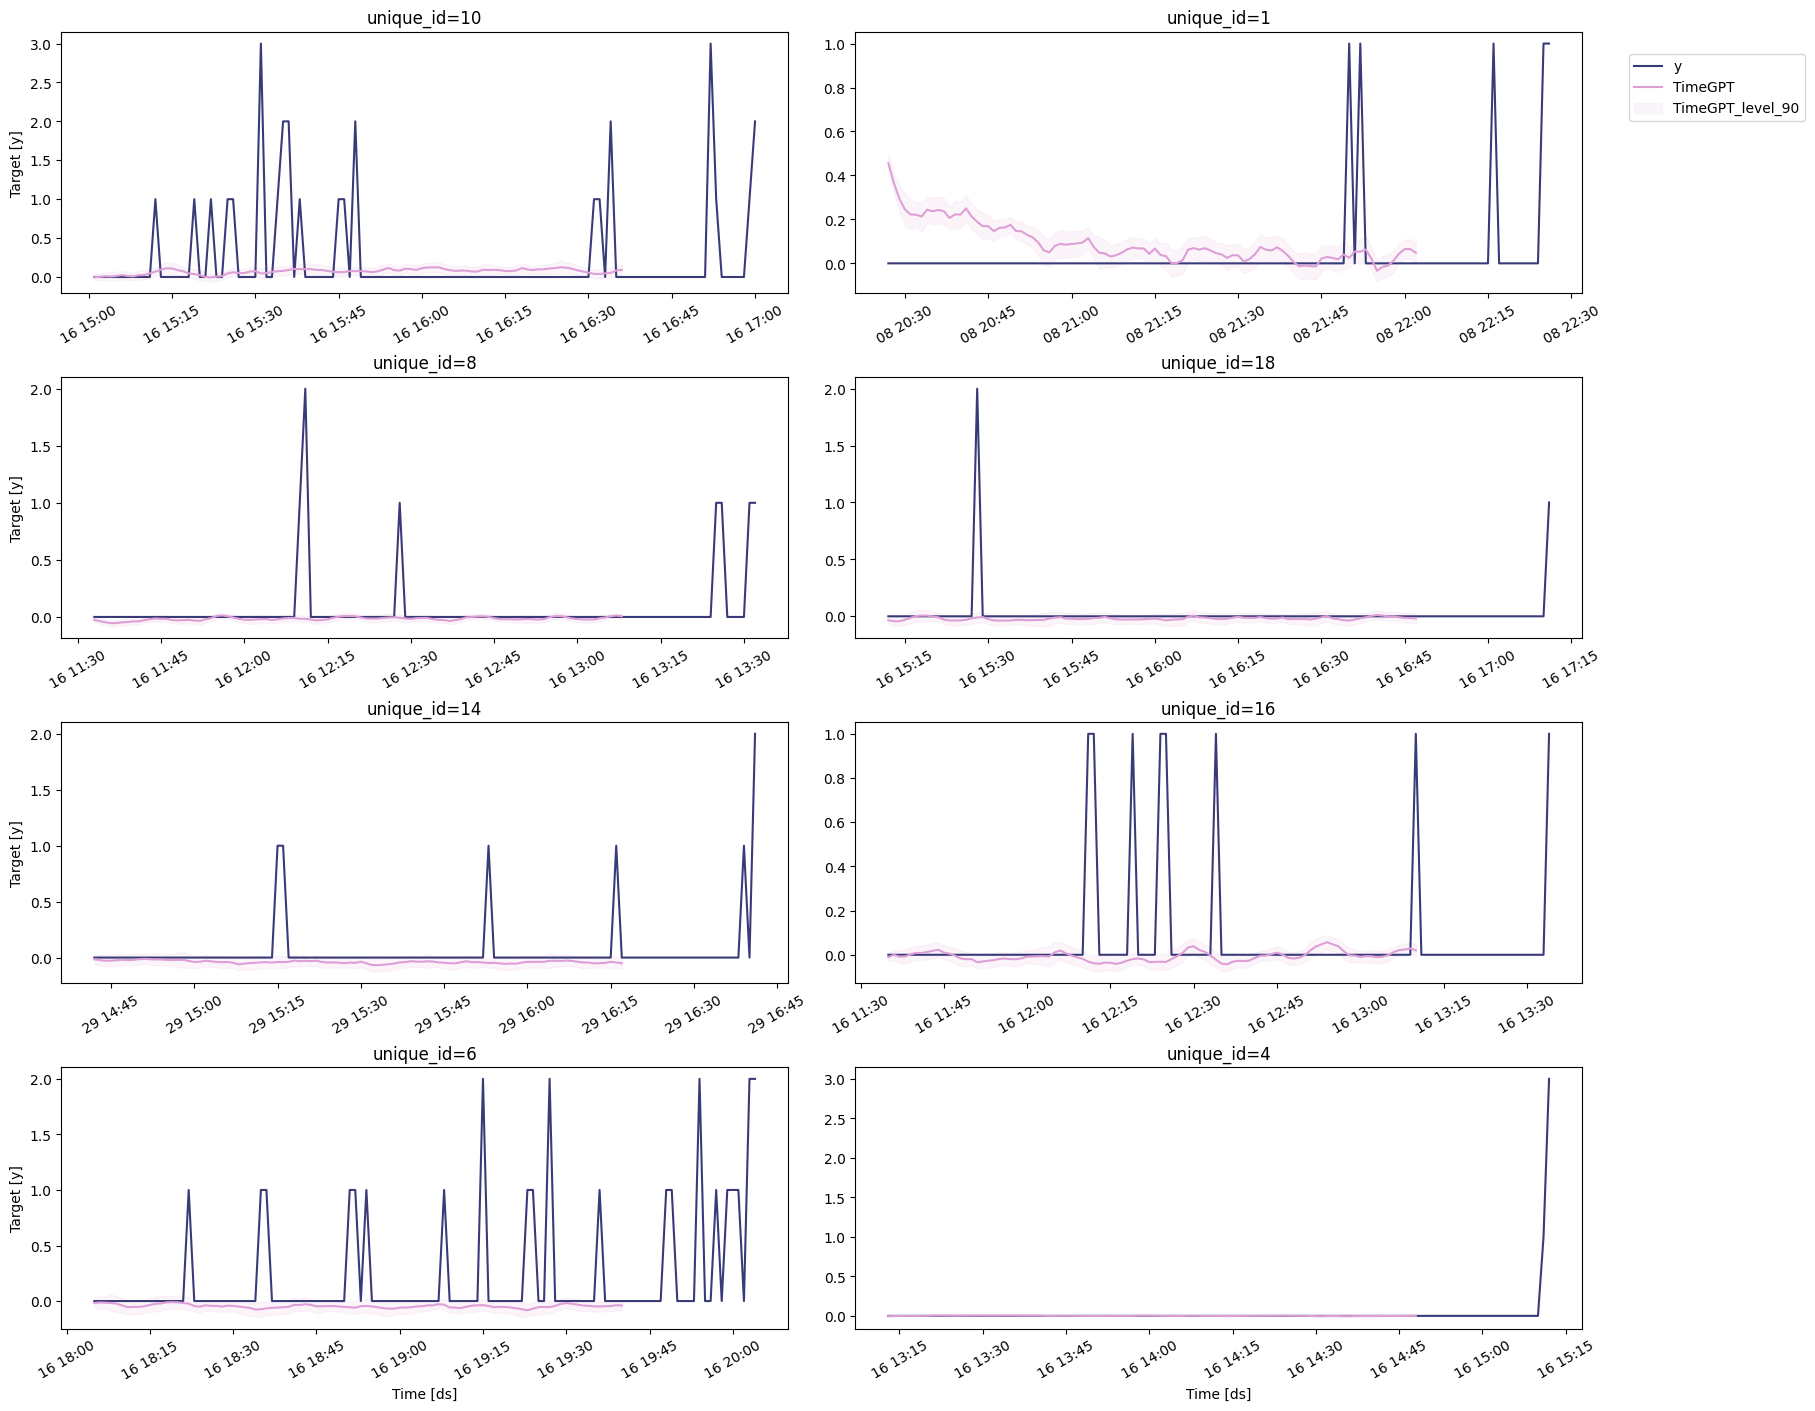

In [15]:
nixtla_client.plot(test_df, fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

In [16]:
fcst_df['ds'] = pd.to_datetime(fcst_df['ds'])

test_df = pd.merge(test_df, fcst_df, 'left', ['unique_id', 'ds'])

In [17]:
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate
evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')['TimeGPT'].mean()
average_metrics

metric
mae      0.093749
smape    0.798968
Name: TimeGPT, dtype: float64

In [28]:
import time
import requests
start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    h=120,                            
    level=[90],                        # Generate a 90% confidence interval
    finetune_steps=100,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

Time (TimeGPT): 10.369081974029541


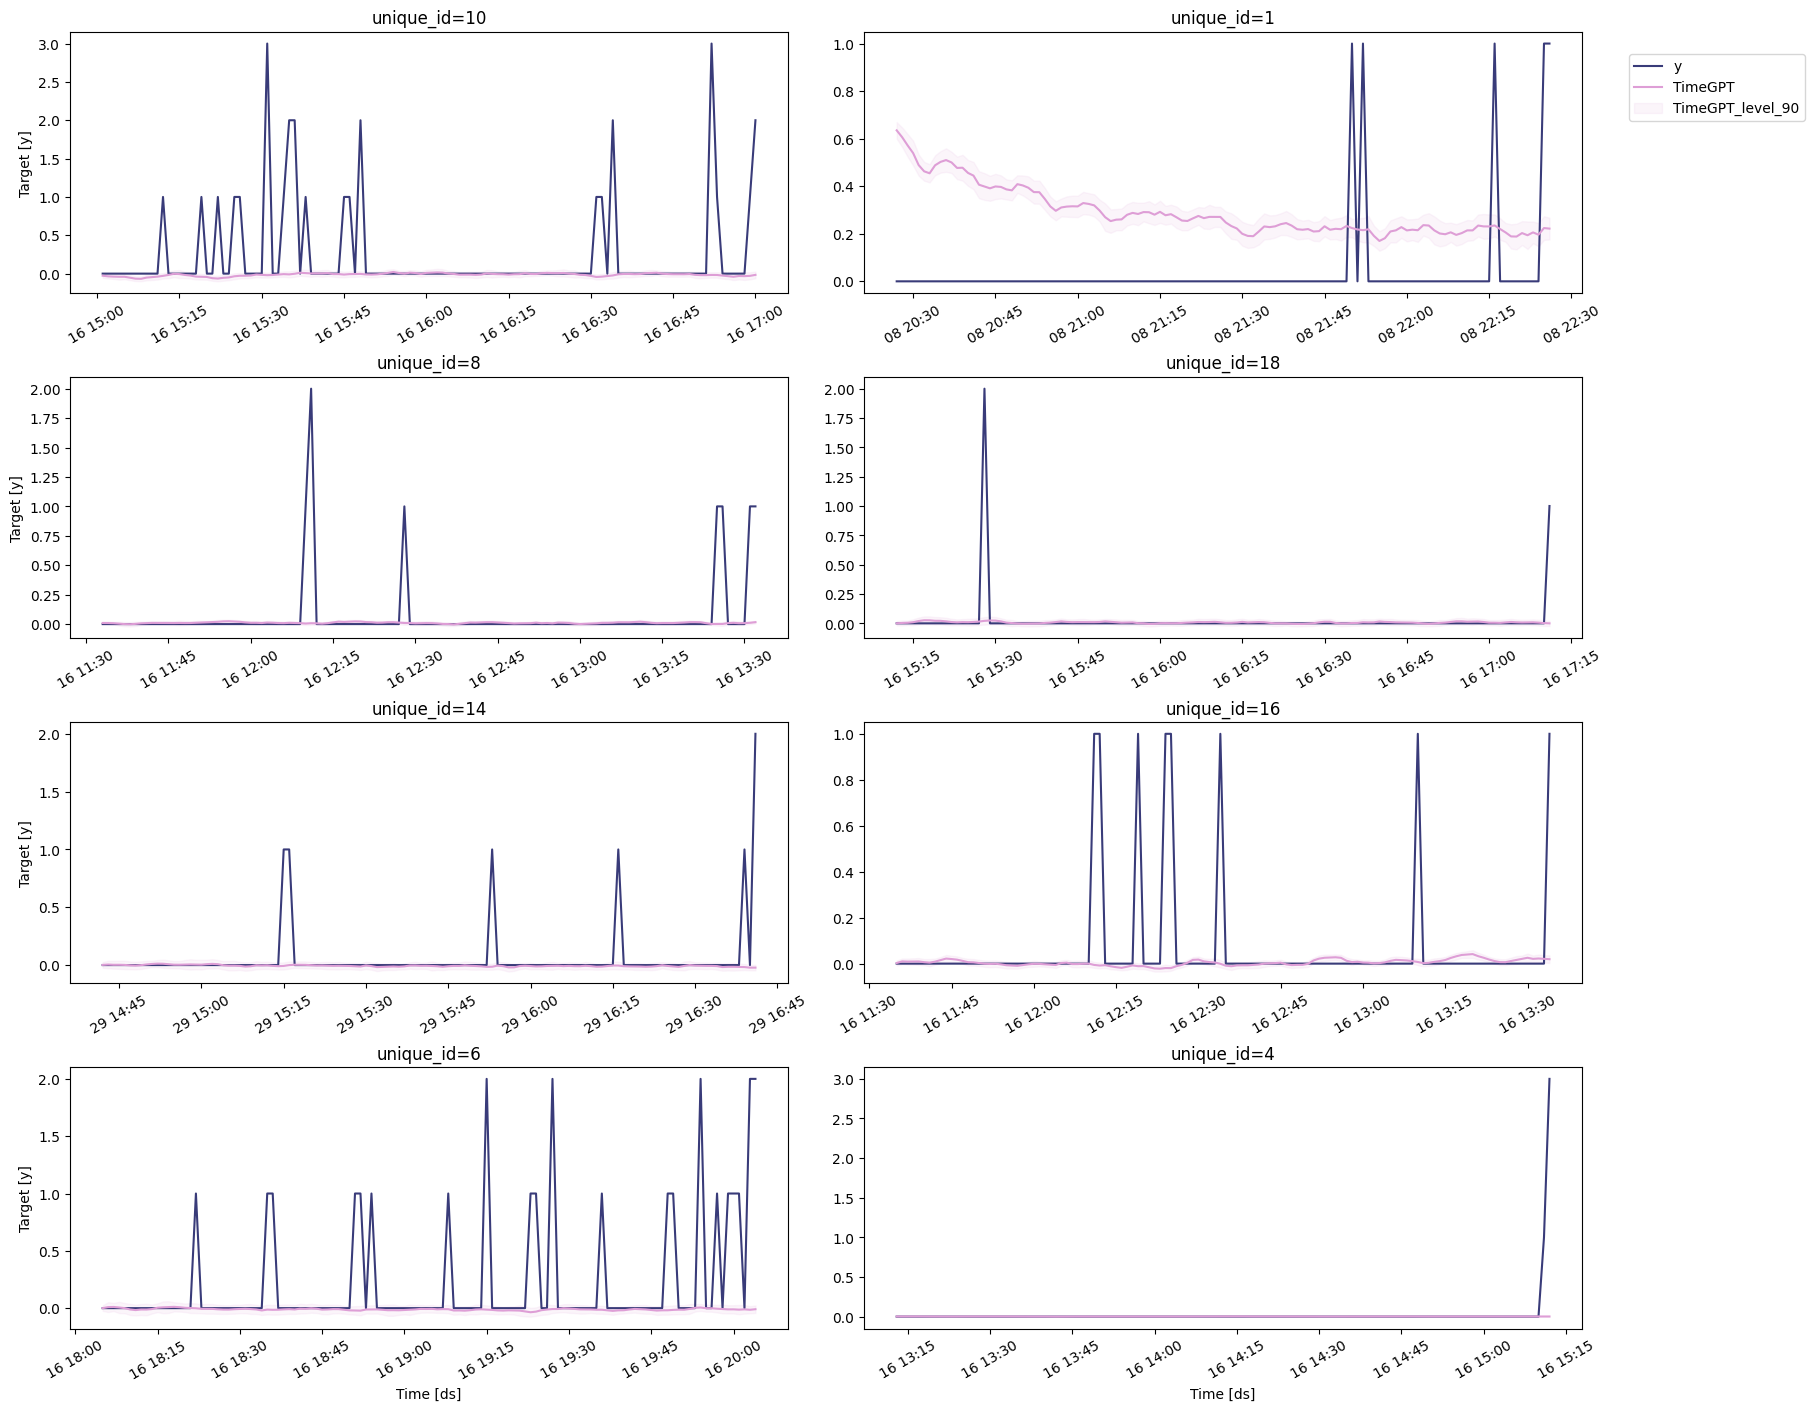

In [29]:
nixtla_client.plot(test_df, fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

In [18]:
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 7.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.9 MB/s eta 0:00:00


In [19]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS

train_df = df_resampled.groupby('unique_id').apply(lambda group: group.iloc[:-120]).reset_index(drop=True)


<ipython-input-19-7ce6fa988302>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = df_resampled.groupby('unique_id').apply(lambda group: group.iloc[:-120]).reset_index(drop=True)


In [20]:
train_df

unique_id                  ds  y
0                 0 2019-09-12 16:31:00  4
1                 0 2019-09-12 16:32:00  1
2                 0 2019-09-12 16:33:00  2
3                 0 2019-09-12 16:34:00  0
4                 0 2019-09-12 16:35:00  1
...             ...                 ... ..
10593317         19 2020-06-15 21:10:00  0
10593318         19 2020-06-15 21:11:00  0
10593319         19 2020-06-15 21:12:00  0
10593320         19 2020-06-15 21:13:00  0
10593321         19 2020-06-15 21:14:00  0

[10593322 rows x 3 columns]

In [21]:
import torch
# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [24]:
import time
horizon = 96

# Initialize NHITS model and move it to the GPU (if available)
models = [NHITS(
    h=horizon,
    input_size=3 * horizon,
    scaler_type='robust',
    batch_size=2,
    valid_batch_size=8
).to(device)]

# Initialize NeuralForecast with the model
nf = NeuralForecast(models=models, freq='min')

# Measure training time
start = time.time()

torch.cuda.empty_cache()
# Train the model
nf.fit(df=train_df)

# Make predictions
nhits_preds = nf.predict()

end = time.time()
nhits_duration = end - start
print(f"Time (N-HiTS): {nhits_duration} seconds")

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Time (N-HiTS): 95.50519347190857 seconds


In [25]:
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate
preds_df = pd.merge(test_df, nhits_preds, 'left', ['unique_id', 'ds'])

evaluation = evaluate(
    preds_df,
    metrics=[mae, smape],
    models=["NHITS"],
    target_col="y",
    id_col='unique_id'
)


average_metrics = evaluation.groupby('metric')['NHITS'].mean()
print(average_metrics)

metric
mae      0.067748
smape    0.799998
Name: NHITS, dtype: float64


In [62]:
# Anamoly detection

anomalies_df = nixtla_client.detect_anomalies(df_resampled, freq='min')
anomalies_df.head(20)

unique_id                  ds  y   TimeGPT  TimeGPT-hi-99  TimeGPT-lo-99  \
0          0 2019-09-12 18:42:00  0  0.005033       1.025951      -1.015884   
1          0 2019-09-12 18:43:00  0  0.003144       1.024062      -1.017774   
2          0 2019-09-12 18:44:00  0  0.006470       1.027388      -1.014447   
3          0 2019-09-12 18:45:00  0  0.001424       1.022341      -1.019494   
4          0 2019-09-12 18:46:00  0  0.002314       1.023231      -1.018604   

   anomaly  
0    False  
1    False  
2    False  
3    False  
4    False

In [69]:
anomalies_df['anomaly'].value_counts()

anomaly
False    10358936
True       234136
Name: count, dtype: int64

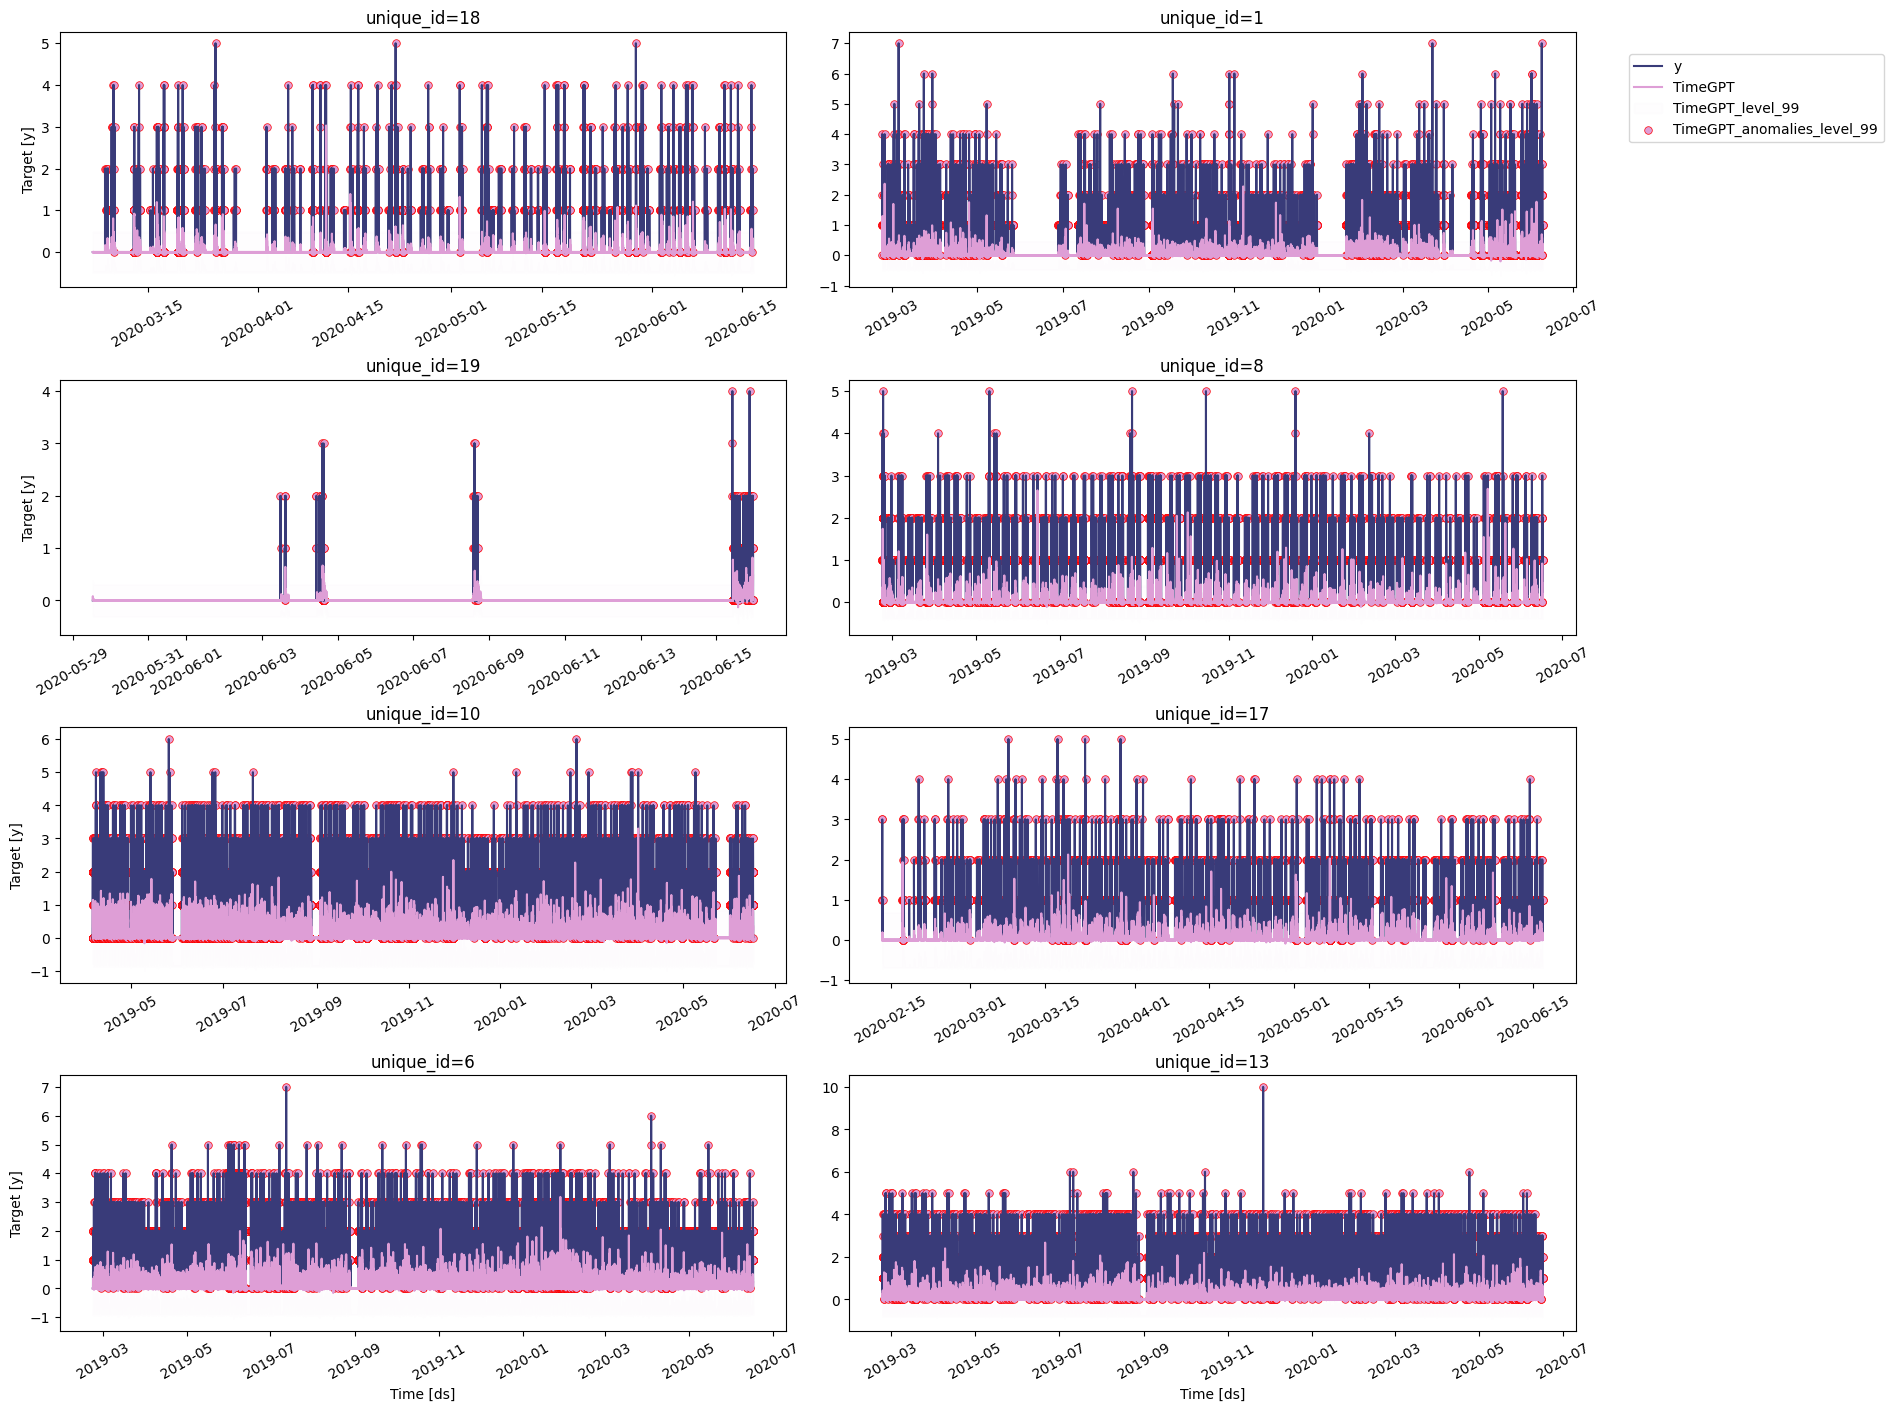

In [71]:
nixtla_client.plot(df_resampled, anomalies_df)